In [1]:
import os
import time
import math
import numpy as np
import random
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from utils import to_gpu, train_ngram_lm, get_ppl, create_exp_dir, Dictionary, length_sort
from models import Seq2Seq, MLP_D, MLP_D_local, MLP_G
from bleu_self import *
from bleu_test import *
import datetime
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [2]:
import argparse

parser = argparse.ArgumentParser(description='TILGAN for unconditional generation')

In [3]:
import pandas as pd
from transformers import *
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [4]:
seed=4
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
#data_path="data/MS_COCO"
#data_path="../../yahoo/unlabelled_small"
save="./results/yelp_merge_results"
maxlen=30
batch_size=24
eval_batch_size = 24
noise_seq_length = 15
add_noise=True #what does this do? - question applies to most parameters
emsize=512
nhidden=512
nlayers=2
nheads=4
nff=1024
aehidden=56
noise_r=0.05
hidden_init=True
dropout=0.3
gpu=True
z_size=100
arch_g='300-300'
gan_g_activation=True
arch_d='300-300'
gan_d_local=False
gan_d_local_windowsize=3
arch_d_local='300-300'
lr_ae=0.12
lr_gan_e=1e-04
beta1=0.5
lr_gan_g=4e-04
lr_gan_d=1e-04
epochs=200
sample=True
clip=1
log_interval=100
gan_lambda=0.1
niters_gan_d=1
niters_gan_g=1
niters_gan_ae=1
niters_gan_dec=1
niters_gan_schedule=''
niters_ae=1
gan_type='kl'
enhance_dec=True
gan_gp_lambda=1
vocab_size=0
lowercase=True

In [6]:
# data="../../yahoo/yahoo_everything.csv"

label_list = ["UNK",1,2,3,4,5]

# df_yahoo = pd.read_csv(data)
# #df_yahoo=df_yahoo.rename(columns = {"Unnamed: 0":'label'})
# df_yahoo=df_yahoo.set_index("Unnamed: 0")
# df = df_yahoo.sample(frac=1)
# df.head()

In [7]:
# numbers=list(df['label'].unique())
# list_zeros = [0]*len(numbers)
# count_dictionary = dict(zip(numbers, list_zeros))

# values_array_train_labelled=[]
# values_array_test_labelled=[]
# values_array_test_unlabelled=[]
# values_array_train_unlabelled=[]
# values_array_unlabelled=[]
# data_all=[]
# for index, row in df.iterrows():
#     if count_dictionary[row['label']]<20:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_train_labelled.append((row['question_1'],row['label']))
#     elif count_dictionary[row['label']]<60:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_test_labelled.append((row['question_1'],row['label']))
#     elif count_dictionary[row['label']]<600:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_unlabelled.append((row['question_1'],'UNK'))
#     elif count_dictionary[row['label']]<1600:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_test_unlabelled.append((row['question_1'],'UNK'))
#     elif count_dictionary[row['label']]<7600:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_train_unlabelled.append((row['question_1'],'UNK'))
#     data_all.append(row['question_1'])

In [8]:
# train_l =  values_array_train_labelled
# test_l = values_array_test_labelled
# test_u = values_array_test_unlabelled
# train_u = values_array_train_unlabelled

In [9]:
df_train_l=pd.read_csv("../../yelp/assigned/train_l.csv", index_col="Unnamed: 0")
df_test_l=pd.read_csv("../../yelp/assigned/test_l.csv", index_col="Unnamed: 0")
df_u=pd.read_csv("../../yelp/assigned/u.csv", index_col="Unnamed: 0")
df_train_u=pd.read_csv("../../yelp/assigned/train_u.csv", index_col="Unnamed: 0")#.head(30000)
df_test_u=pd.read_csv("../../yelp/assigned/test_u.csv", index_col="Unnamed: 0")#.head(5000)
df_all = pd.concat([df_train_l, df_test_l, df_u, df_train_u, df_test_u])

In [10]:
train_l =  list(df_train_l.to_records(index=False))
test_l = list(df_test_l.to_records(index=False))
u_list = list(df_u.to_records(index=False))
test_u = list(df_test_u.to_records(index=False))
train_u = list(df_train_u.to_records(index=False))
data_all = list(df_all["0"])

In [11]:
class Corpus(object):
    def __init__(self, data_all, train_l, test_l, train_u, test_u, maxlen, vocab_size=11000, lowercase=False):
        self.dictionary = Dictionary()
        self.maxlen = maxlen
        self.lowercase = lowercase
        self.vocab_size = vocab_size
        
        self.data_all = data_all
        self.train_l = train_l
        self.test_l = test_l
        self.train_u = train_u
        self.test_u = test_u

        # make the vocabulary from training set
        self.make_vocab()
        
        self.train_l_tok = self.tokenize(self.train_l)
        self.test_l_tok = self.tokenize(self.test_l)
        self.train_u_tok = self.tokenize(self.train_u)
        self.test_u_tok = self.tokenize(self.test_u)

    def make_vocab(self):
        # Add words to the dictionary
        print(len(self.data_all))
        print(self.data_all[0])
        for line in self.data_all:
            if self.lowercase:
                # -1 to get rid of \n character
                words = line[:-1].lower().split(" ")
            else:
                words = line[:-1].split(" ")
            for word in words:
                self.dictionary.add_word(word)

        # prune the vocabulary
        self.dictionary.prune_vocab(k=self.vocab_size, cnt=True)

    def tokenize(self, data):
        """Tokenizes a text file."""
        dropped = 0
        #with open(path, 'r') as f:
        linecount = 0
        lines = []
        for line, label in data:
            linecount += 1
            if self.lowercase:
                words = line[:-1].lower().strip().split(" ")
            else:
                words = line[:-1].strip().split(" ")
            if len(words) > self.maxlen:
                dropped += 1
                continue
            words = ['<sos>'] + words
            words += ['<eos>']
            # vectorize
            vocab = self.dictionary.word2idx
            unk_idx = vocab['<oov>']
            indices = [vocab[w] if w in vocab else unk_idx for w in words]
            lines.append(indices)

        print("Number of sentences dropped: {} out of {} total".
              format(dropped, linecount))
        return lines

In [12]:
corpus = Corpus(data_all = data_all,
                train_l=train_l,
                test_l=test_l,
                train_u=train_u,
                test_u=test_u,
                maxlen=maxlen,
                vocab_size=vocab_size,
                lowercase=lowercase)

75300
Huge gender imbalance and rude staff.
original vocab 85023; pruned to 85027
Number of sentences dropped: 0 out of 100 total
Number of sentences dropped: 0 out of 200 total
Number of sentences dropped: 8 out of 60000 total
Number of sentences dropped: 1 out of 10000 total


In [13]:
# save arguments
ntokens = len(corpus.dictionary.word2idx)
print("Vocabulary Size: {}".format(ntokens))

Vocabulary Size: 85027


In [14]:
# exp dir
create_exp_dir(os.path.join(save), ['train.py', 'models.py', 'utils.py'],
        dict=corpus.dictionary.word2idx)

Experiment dir : ./results/yelp_merge_results


In [15]:
def logging(str, to_stdout=True):
    with open(os.path.join(save, 'log.txt'), 'a') as f:
        f.write(str + '\n')
    if to_stdout:
        print(str)

In [16]:
def batchify(data, bsz, max_len, shuffle=False, gpu=False):
    if shuffle:
        random.shuffle(data)
    nbatch = len(data) // bsz
    batches = []

    for i in range(nbatch):
        maxlen = max_len+1
        # Pad batches to maximum sequence length in batch
        batch = data[i*bsz:(i+1)*bsz]
        # subtract 1 from lengths b/c includes BOTH starts & end symbols
        lengths = [len(x)-1 for x in batch]

        # sort items by length (decreasing)
        batch, lengths = length_sort(batch, lengths)

        # source has no end symbol
        source = [x[:-1] for x in batch]
        # target has no start symbol
        target = [x[1:] for x in batch]


        for x, y in zip(source, target):
            zeros = (maxlen-len(x))*[0]
            x += zeros
            y += zeros
        source = torch.LongTensor(np.array(source))
        target = torch.LongTensor(np.array(target)).view(-1)

        if gpu:
            source = source.cuda()
            target = target.cuda()

        batches.append((source, target, lengths))

    return batches

In [17]:
test_data = batchify(corpus.test_u_tok, eval_batch_size, maxlen, shuffle=False)
train_data = batchify(corpus.train_u_tok, batch_size, maxlen,  shuffle=True)

print("Loaded data!")

Loaded data!


In [18]:
print(len(test_data))
print(len(train_data))

416
2499


In [19]:
###############################################################################
# Build the models
###############################################################################
autoencoder = Seq2Seq(add_noise=add_noise,
                      emsize=emsize,
                      nhidden=nhidden,
                      ntokens=ntokens,
                      nlayers=nlayers,
                      nheads=nheads,
                      nff=nff,
                      aehidden=aehidden,
                      noise_r=noise_r,
                      hidden_init=hidden_init,
                      dropout=dropout,
                      gpu=True)
nlatent = aehidden * (maxlen+1)
gan_gen = MLP_G(ninput=z_size, noutput=nlatent, layers=arch_g, gan_g_activation=gan_g_activation)
gan_disc = MLP_D(ninput=nlatent, noutput=1, layers=arch_d)
gan_disc_local = MLP_D_local(ninput=gan_d_local_windowsize * aehidden, noutput=1, layers=arch_d_local)

optimizer_ae = optim.SGD(autoencoder.parameters(), lr=lr_ae)


optimizer_gan_e = optim.Adam(autoencoder.encoder.parameters(),
                             lr=lr_gan_e,
                             betas=(beta1, 0.999))
optimizer_gan_g = optim.Adam(gan_gen.parameters(),
                             lr=lr_gan_g,
                             betas=(beta1, 0.999))
optimizer_gan_d = optim.Adam(gan_disc.parameters(),
                             lr=lr_gan_d,
                             betas=(beta1, 0.999))
optimizer_gan_d_local = optim.Adam(gan_disc_local.parameters(),
                             lr=lr_gan_d,
                             betas=(beta1, 0.999))
optimizer_gan_dec = optim.Adam(autoencoder.decoder.parameters(),
                             lr=lr_gan_e,
                             betas=(beta1, 0.999))

autoencoder = autoencoder.to(device)
gan_gen = gan_gen.to(device)
gan_disc = gan_disc.to(device)
gan_disc_local = gan_disc_local.to(device)

In [20]:
def save_model():
    print("Saving models to {}".format(save))
    torch.save({
        "ae": autoencoder.state_dict(),
        "gan_g": gan_gen.state_dict(),
        "gan_d": gan_disc.state_dict(),
        "gan_d_local": gan_disc_local.state_dict()

        },
        os.path.join(save, "model.pt"))

In [21]:
def cal_norm(model):
    total_norm = 0
    for p in model.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

In [22]:
def load_models():
    model_args = json.load(open(os.path.join(save, 'options.json'), 'r'))
    word2idx = json.load(open(os.path.join(save, 'vocab.json'), 'r'))
    idx2word = {v: k for k, v in word2idx.items()}

    print('Loading models from {}'.format(save))
    loaded = torch.load(os.path.join(save, "model.pt"))
    autoencoder.load_state_dict(loaded.get('ae'))
    gan_gen.load_state_dict(loaded.get('gan_g'))
    gan_disc.load_state_dict(loaded.get('gan_d'))
    gan_disc_local.load_state_dict(loaded.get('gan_d_local'))
    return model_args, idx2word, autoencoder, gan_gen, gan_disc

In [23]:
def evaluate_autoencoder(data_source, epoch):
    # Turn on evaluation mode which disables dropout.
    autoencoder.eval()
    total_loss = 0
    ntokens = len(corpus.dictionary.word2idx)
    all_accuracies = 0
    bcnt = 0
    for i, batch in enumerate(data_source):
        source, target, lengths = batch
        with torch.no_grad():
            source = Variable(source.to(device))
            target = Variable(target.to(device))
            mask = target.gt(0)
            masked_target = target.masked_select(mask)
            # examples x ntokens
            output_mask = mask.unsqueeze(1).expand(mask.size(0), ntokens)

            # output: batch x seq_len x ntokens
            output = autoencoder(source, lengths, source, add_noise=add_noise, soft=False)
            flattened_output = output.view(-1, ntokens)

            masked_output = \
                flattened_output.masked_select(output_mask).view(-1, ntokens)
            total_loss += F.cross_entropy(masked_output, masked_target)

            # accuracy
            max_vals, max_indices = torch.max(masked_output, 1)
            accuracy = torch.mean(max_indices.eq(masked_target).float()).data.item()
            all_accuracies += accuracy
            bcnt += 1

        aeoutf = os.path.join(save, "autoencoder.txt")
        with open(aeoutf, "w") as f:
            max_values, max_indices = torch.max(output, 2)
            max_indices = \
                max_indices.view(output.size(0), -1).data.cpu().numpy()
            target = target.view(output.size(0), -1).data.cpu().numpy()
            for t, idx in zip(target, max_indices):
                # real sentence
                chars = " ".join([corpus.dictionary.idx2word[x] for x in t])
                f.write(chars + '\n')
                # autoencoder output sentence
                chars = " ".join([corpus.dictionary.idx2word[x] for x in idx])
                f.write(chars + '\n'*2)

    return total_loss.item() / len(data_source), all_accuracies/bcnt

In [24]:
def gen_fixed_noise(noise, to_save):
    gan_gen.eval()
    autoencoder.eval()

    fake_hidden = gan_gen(noise)
    max_indices = autoencoder.generate(fake_hidden, maxlen, sample=sample)

    with open(to_save, "w") as f:
        max_indices = max_indices.data.cpu().numpy()
        for idx in max_indices:
            # generated sentence
            words = [corpus.dictionary.idx2word[x] for x in idx]
            # truncate sentences to first occurrence of <eos>
            truncated_sent = []
            for w in words:
                if w != '<eos>':
                    truncated_sent.append(w)
                else:
                    break
            chars = " ".join(truncated_sent)
            f.write(chars + '\n')

In [25]:
def gen_fixed_noise_new(noise):
    gan_gen.eval()
    autoencoder.eval()

    fake_hidden = gan_gen(noise)
    max_indices = autoencoder.generate(fake_hidden, maxlen, sample=sample)
    
    sent_list = []
    
    #with open(to_save, "w") as f:
    max_indices = max_indices.data.cpu().numpy()
    for idx in max_indices:
        # generated sentence
        words = [corpus.dictionary.idx2word[x] for x in idx]
        # truncate sentences to first occurrence of <eos>
        truncated_sent = []
        for w in words:
            if w != '<eos>':
                truncated_sent.append(w)
            else:
                break
        chars = " ".join(truncated_sent)
        #f.write(chars + '\n')
        sent_list.append(chars)
    #print(sent_list)
    return sent_list

In [26]:
def eval_bleu(gen_text_savepath):
    selfbleu = bleu_self(gen_text_savepath)
    real_text = os.path.join(data_path, "test.txt")
    testbleu = bleu_test(real_text, gen_text_savepath)
    return selfbleu, testbleu

In [27]:
def train_ae(epoch, batch, total_loss_ae, start_time, i):
    '''Train AE with the negative log-likelihood loss'''
    autoencoder.train()
    optimizer_ae.zero_grad()

    source, target, lengths = batch
    source = Variable(source.to(device))
    target = Variable(target.to(device))
    output = autoencoder(source, lengths, source, add_noise=add_noise, soft=False)

    mask = target.gt(0)
    masked_target = target.masked_select(mask)
    output_mask = mask.unsqueeze(1).expand(mask.size(0), ntokens)
    flat_output = output.view(-1, ntokens)
    masked_output = flat_output.masked_select(output_mask).view(-1, ntokens)
    loss = F.cross_entropy(masked_output, masked_target)
    loss.backward()
    torch.nn.utils.clip_grad_norm(autoencoder.parameters(), clip)
    train_ae_norm = cal_norm(autoencoder)
    optimizer_ae.step()

    total_loss_ae += loss.data.item()
    if i % log_interval == 0:
        probs = F.softmax(masked_output, dim=-1)
        max_vals, max_indices = torch.max(probs, 1)
        accuracy = torch.mean(max_indices.eq(masked_target).float()).data.item()
        cur_loss = total_loss_ae / log_interval
        elapsed = time.time() - start_time
        logging('| epoch {:3d} | {:5d}/{:5d} batches | lr {:08.6f} | ms/batch {:5.2f} | '
                'loss {:5.2f} | ppl {:8.2f} | acc {:8.2f} | train_ae_norm {:8.2f}'.format(
                epoch, i, len(train_data), 0,
                elapsed * 1000 / log_interval,
                cur_loss, math.exp(cur_loss), accuracy, train_ae_norm))

        total_loss_ae = 0
        start_time = time.time()
    return total_loss_ae, start_time

In [28]:
def train_gan_g(gan_type='kl'):
    gan_gen.train()
    optimizer_gan_g.zero_grad()

    z = Variable(torch.Tensor(batch_size, z_size).normal_(0, 1).to(device))
    fake_hidden = gan_gen(z)
    fake_score = gan_disc(fake_hidden)

    if gan_d_local:
        idx = random.randint(0, maxlen - gan_d_local_windowsize)
        fake_hidden_local = fake_hidden[:, idx * aehidden : (idx + gan_d_local_windowsize) * aehidden]
        fake_score_local = gan_disc_local(fake_hidden_local)

        if gan_type == 'kl':
            errG = -(torch.exp(fake_score.detach()).clamp(0.5, 2) * fake_score).mean() -(torch.exp(fake_score_local.detach()).clamp(0.5, 2) * fake_score_local).mean()
        else:
            errG = -fake_score.mean() -fake_score_local.mean()
    else:
        if gan_type == 'kl':
            errG = -(torch.exp(fake_score.detach()).clamp(0.5, 2) * fake_score).mean()
        else:
            errG = -fake_score.mean()


    errG *= gan_lambda
    errG.backward()
    optimizer_gan_g.step()

    return errG

In [29]:
def train_gan_dec(gan_type='kl'):
    autoencoder.decoder.train()
    optimizer_gan_dec.zero_grad()

    z = Variable(torch.Tensor(batch_size, z_size).normal_(0, 1).to(device))
    fake_hidden = gan_gen(z)

    # 1. decoder  - soft distribution
    enhance_source, max_indices= autoencoder.generate_enh_dec(fake_hidden, maxlen, sample=sample)
    # 2. soft distribution - > encoder  -> fake_hidden
    enhance_hidden = autoencoder(enhance_source, None, max_indices, add_noise=add_noise, soft=True, encode_only=True)
    fake_score = gan_disc(enhance_hidden)

    if gan_d_local:
        idx = random.randint(0, maxlen - gan_d_local_windowsize)
        fake_hidden_local = fake_hidden[:, idx * aehidden : (idx + gan_d_local_windowsize) * aehidden]
        fake_score_local = gan_disc_local(fake_hidden_local)

        if gan_type == 'kl':
            errG = -(torch.exp(fake_score.detach()).clamp(0.5, 2) * fake_score).mean() -(torch.exp(fake_score_local.detach()).clamp(0.5, 2) * fake_score_local).mean()
        else:
            errG = -fake_score.mean() -fake_score_local.mean()
    else:
        if gan_type == 'kl':
            errG = -(torch.exp(fake_score.detach()).clamp(0.5, 2) * fake_score).mean()
        else:
            errG = -fake_score.mean()


    errG *= gan_lambda
    errG.backward()
    optimizer_gan_dec.step()

    return errG

In [30]:
def grad_hook(grad):
    return grad * gan_lambda

In [31]:
''' Steal from https://github.com/caogang/wgan-gp/blob/master/gan_cifar10.py '''
def calc_gradient_penalty(netD, real_data, fake_data):
    bsz = real_data.size(0)
    alpha = torch.rand(bsz, 1)
    alpha = alpha.expand(bsz, real_data.size(1))  # only works for 2D XXX
    alpha = alpha.to(device)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gan_gp_lambda
    return gradient_penalty

In [32]:
def train_gan_d(batch, gan_type='kl'):
    gan_disc.train()
    gan_disc_local.train()
    optimizer_gan_d.zero_grad()
    optimizer_gan_d_local.zero_grad()

    # + samples
    source, target, lengths = batch
    source = Variable(source.to(device))
    target = Variable(target.to(device))
    real_hidden = autoencoder(source, lengths, source, add_noise=add_noise, soft=False, encode_only=True)
    real_score = gan_disc(real_hidden.detach())

    idx = random.randint(0, maxlen - gan_d_local_windowsize)
    if gan_d_local:
        real_hidden_local = real_hidden[:, idx * aehidden : (idx + gan_d_local_windowsize) * aehidden]
        real_score_local = gan_disc_local(real_hidden_local)
        real_score += real_score_local


    if gan_type == 'wgan':
        errD_real = -real_score.mean()
    else: # kl or all
        errD_real = F.softplus(-real_score).mean()
    errD_real.backward()

    # - samples
    z = Variable(torch.Tensor(batch_size, z_size).normal_(0, 1).to(device))
    fake_hidden = gan_gen(z)
    fake_score = gan_disc(fake_hidden.detach())

    if gan_d_local:
        fake_hidden_local = fake_hidden[:, idx * aehidden : (idx + gan_d_local_windowsize) * aehidden]
        fake_score_local = gan_disc_local(fake_hidden_local)
        fake_score += fake_score_local

    if gan_type == 'wgan':
        errD_fake = fake_score.mean()
    else:  # kl or all
        errD_fake = F.softplus(fake_score).mean()
    errD_fake.backward()

    # gradient penalty
    if gan_type == 'wgan':
        gradient_penalty = calc_gradient_penalty(gan_disc, real_hidden.data, fake_hidden.data)
        gradient_penalty.backward()

    optimizer_gan_d.step()
    optimizer_gan_d_local.step()
    return errD_real + errD_fake, errD_real, errD_fake

In [33]:
def train_gan_d_into_ae(batch):
    autoencoder.train()
    optimizer_gan_e.zero_grad()

    source, target, lengths = batch
    source = Variable(source.to(device))
    target = Variable(target.to(device))
    real_hidden = autoencoder(source, lengths, source, add_noise=add_noise, soft=False, encode_only=True)

    if gan_d_local:
        idx = random.randint(0, maxlen - gan_d_local_windowsize)
        real_hidden_local = real_hidden[:, idx * aehidden : (idx + gan_d_local_windowsize) * aehidden]
        real_score_local = gan_disc_local(real_hidden_local)
        errD_real = gan_disc(real_hidden).mean() + real_score_local.mean()
    else:
        errD_real = gan_disc(real_hidden).mean()

    errD_real *= gan_lambda
    errD_real.backward()
    torch.nn.utils.clip_grad_norm(autoencoder.parameters(), clip)

    optimizer_gan_e.step()
    return errD_real

In [34]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size_d = 48

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
#num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-6 #5e-5?
#learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 50
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

#model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name="google/electra-large-discriminator"
#model_name="google/electra-small-discriminator"
#model_name="microsoft/deberta-v2-xxlarge"
#model_name="microsoft/deberta-v3-base"
model_name = "google/electra-base-discriminator"

In [35]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /home/harry/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transform

In [36]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [37]:
def generate_data_fake(input_examples):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []

  # Tokenization 
  for text in input_examples:
    encoded_sent = tokenizer.encode(text, add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)

  # Building the DataLoader
  return input_ids, input_mask_array # Trains with this batch size.

In [38]:
#Load the examples
labeled_examples = train_l
unlabeled_examples = u_list
test_examples = test_l

In [39]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

In [40]:
#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [41]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
#hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
#generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  #generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /home/harry/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transform

In [42]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

In [43]:
training_stats = []

accuracy_array=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
#g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
#gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

In [44]:
def train():
    logging("Training")
    train_data = batchify(corpus.train_u_tok, batch_size, maxlen, shuffle=True)

    # gan: preparation
    if niters_gan_schedule != "":
        gan_schedule = [int(x) for x in niters_gan_schedule.split("-")]
    else:
        gan_schedule = []
    niter_gan = 1
    fixed_noise = Variable(torch.ones(eval_batch_size, z_size).normal_(0, 1).to(device))

    for epoch in range(1, epochs+1):
        # update gan training schedule
        if epoch in gan_schedule:
            niter_gan += 1
            logging("GAN training loop schedule: {}".format(niter_gan))

        total_loss_ae = 0
        epoch_start_time = time.time()
        start_time = time.time()
        niter = 0
        niter_g = 1
        print("Train classification discriminator")
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        tr_g_loss = 0
        tr_d_loss = 0

        # Put the model into training mode.
        transformer.train() 
        #generator.train()
        discriminator.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every print_each_n_step batches.
            if step % print_each_n_step == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            b_label_mask = batch[3].to(device)

            real_batch_size = b_input_ids.shape[0]

            # Encode real data in the Transformer
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs.last_hidden_state[:,0,:] 
            #hidden_states = model_outputs[-1]
            #print("  Number of real sentences (labelled and unlabelled): {}".format(len(hidden_states)))
            
            # Generate fake data that should have the same distribution of the ones
            # encoded by the transformer. 
            # First noisy input are used in input to the Generator
            fixed_noise = Variable(torch.ones(real_batch_size, 100).normal_(0, 1).to(device))
            fake_sentences = gen_fixed_noise_new(fixed_noise)
            #print("  Number of generated sentences: {}".format(len(fake_sentences)))

            b_input_ids_fake, b_input_mask_fake = generate_data_fake(fake_sentences)
            model_outputs_fake = transformer(b_input_ids_fake, attention_mask=b_input_mask_fake)
            hidden_states_fake = model_outputs_fake.last_hidden_state[:,0,:] 
            #hidden_states_fake = model_outputs_fake[-1]

            #noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
            # Gnerate Fake data
            #gen_rep = generator(noise)
            #print("Length of generator output {}".format(len(gen_rep)))
            #print("Length of single generator output {}".format(len(gen_rep[0])))

            # Generate the output of the Discriminator for real and fake data.
            # First, we put together the output of the tranformer and the generator
            disciminator_input = torch.cat([hidden_states, hidden_states_fake], dim=0)
            # Then, we select the output of the disciminator
            features, logits, probs = discriminator(disciminator_input)

            # Finally, we separate the discriminator's output for the real and fake
            # data
            features_list = torch.split(features, real_batch_size)
            D_real_features = features_list[0]
            D_fake_features = features_list[1]

            logits_list = torch.split(logits, real_batch_size)
            D_real_logits = logits_list[0]
            D_fake_logits = logits_list[1]

            probs_list = torch.split(probs, real_batch_size)
            D_real_probs = probs_list[0]
            D_fake_probs = probs_list[1]

            #---------------------------------
            #  LOSS evaluation
            #---------------------------------
            # Generator's LOSS estimation
            g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
            g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
            g_loss = g_loss_d + g_feat_reg

            # Disciminator's LOSS estimation
            logits = D_real_logits[:,0:-1]
            log_probs = F.log_softmax(logits, dim=-1)
            # The discriminator provides an output for labeled and unlabeled real data
            # so the loss evaluated for unlabeled data is ignored (masked)
            label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
            per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
            per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
            labeled_example_count = per_example_loss.type(torch.float32).numel()

            # It may be the case that a batch does not contain labeled examples, 
            # so the "supervised loss" in this case is not evaluated
            if labeled_example_count == 0:
              D_L_Supervised = 0
            else:
              D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

            D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
            D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
            d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

            #---------------------------------
            #  OPTIMIZATION
            #---------------------------------
            # Avoid gradient accumulation
            #gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()

            # Calculate weigth updates
            # retain_graph=True is required since the underlying graph will be deleted after backward
            g_loss.backward(retain_graph=True)
            d_loss.backward() 

            # Apply modifications
            #gen_optimizer.step()
            dis_optimizer.step()

            # A detail log of the individual losses
            #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
            #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
            #             g_loss_d, g_feat_reg))

            # Save the losses to print them later
            tr_g_loss += g_loss.item()
            tr_d_loss += d_loss.item()

            # Update the learning rate with the scheduler
            if apply_scheduler:
              scheduler_d.step()
              #scheduler_g.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss_g = tr_g_loss / len(train_dataloader)
        avg_train_loss_d = tr_d_loss / len(train_dataloader)             

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
        print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #     TEST ON THE EVALUATION DATASET
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our test set.
        print("")
        print("Running Test...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        transformer.eval() #maybe redundant
        discriminator.eval()
        #generator.eval()

        # Tracking variables 
        total_test_accuracy = 0

        total_test_loss = 0
        nb_test_steps = 0

        all_preds = []
        all_labels_ids = []

        #loss
        nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

        # Evaluate data for one epoch
        for batch in test_dataloader:

            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
                model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
                hidden_states = model_outputs.last_hidden_state[:,0,:] 
                #hidden_states = model_outputs[-1]
                _, logits, probs = discriminator(hidden_states)
                ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
                filtered_logits = logits[:,0:-1]
                # Accumulate the test loss.
                total_test_loss += nll_loss(filtered_logits, b_labels)

            # Accumulate the predictions and the input labels
            _, preds = torch.max(filtered_logits, 1)
            all_preds += preds.detach().cpu()
            all_labels_ids += b_labels.detach().cpu()

        # Report the final accuracy for this validation run.
        all_preds = torch.stack(all_preds).numpy()
        all_labels_ids = torch.stack(all_labels_ids).numpy()
        test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
        print("  Accuracy: {0:.3f}".format(test_accuracy))

        # Calculate the average loss over all of the batches.
        avg_test_loss = total_test_loss / len(test_dataloader)
        avg_test_loss = avg_test_loss.item()

        # Measure how long the validation run took.
        test_time = format_time(time.time() - t0)

        print("  Test Loss: {0:.3f}".format(avg_test_loss))
        print("  Test took: {:}".format(test_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss generator': avg_train_loss_g,
                'Training Loss discriminator': avg_train_loss_d,
                'Valid. Loss': avg_test_loss,
                'Valid. Accur.': test_accuracy,
                'Training Time': training_time,
                'Test Time': test_time
            }
        )

        accuracy_array.append(test_accuracy)
        print("Train other shit")
        while niter < len(train_data):
            # train ae
            for i in range(niters_ae):
                if niter >= len(train_data):
                    break  # end of epoch
                total_loss_ae, start_time = train_ae(epoch, train_data[niter],
                                total_loss_ae, start_time, niter)
                niter += 1
            # train gan
            for k in range(niter_gan):
                for i in range(niters_gan_d):
                    errD, errD_real, errD_fake = train_gan_d(
                            train_data[random.randint(0, len(train_data)-1)], gan_type)
                for i in range(niters_gan_ae):
                    train_gan_d_into_ae(train_data[random.randint(0, len(train_data)-1)])
                for i in range(niters_gan_g):
                    errG = train_gan_g(gan_type)
                if enhance_dec:
                    for i in range(niters_gan_dec):
                        errG_enh_dec = train_gan_dec()
                else:
                    errG_enh_dec = torch.Tensor([0])

            niter_g += 1
            if niter_g % log_interval == 0:
                logging('[{}/{}][{}/{}] Loss_D: {:.8f} (Loss_D_real: {:.8f} '
                        'Loss_D_fake: {:.8f}) Loss_G: {:.8f} Loss_Enh_Dec: {:.8f}'.format(
                         epoch, epochs, niter, len(train_data),
                         errD.data.item(), errD_real.data.item(),
                         errD_fake.data.item(), errG.data.item(), errG_enh_dec.data.item()))
        # eval
        test_loss, accuracy = evaluate_autoencoder(test_data, epoch)
        logging('| end of epoch {:3d} | time: {:5.2f}s | test loss {:5.2f} | '
                'test ppl {:5.2f} | acc {:3.3f}'.format(epoch,
                (time.time() - epoch_start_time), test_loss,
                math.exp(test_loss), accuracy))

        gen_text_savepath = os.path.join(save, "{:03d}_examplar_gen".format(epoch))
        gen_fixed_noise(fixed_noise, gen_text_savepath)
#         if epoch % 5 == 0 or epoch % 4 == 0 or (epochs - epoch) <=2:
#             selfbleu, testbleu = eval_bleu(gen_text_savepath)
#             logging('bleu_self: [{:.8f},{:.8f},{:.8f},{:.8f},{:.8f}]'.format(selfbleu[0], selfbleu[1], selfbleu[2], selfbleu[3], selfbleu[4]))
#             logging('bleu_test: [{:.8f},{:.8f},{:.8f},{:.8f},{:.8f}]'.format(testbleu[0], testbleu[1], testbleu[2], testbleu[3], testbleu[4]))

        if epoch % 15 == 0 or epoch == epochs-1:
            logging("New saving model: epoch {:03d}.".format(epoch))
            save_model()

In [45]:
train()

Training
Train classification discriminator

======== Epoch 1 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:07.
  Batch    20  of    230.    Elapsed: 0:00:14.
  Batch    30  of    230.    Elapsed: 0:00:20.
  Batch    40  of    230.    Elapsed: 0:00:27.
  Batch    50  of    230.    Elapsed: 0:00:34.
  Batch    60  of    230.    Elapsed: 0:00:41.
  Batch    70  of    230.    Elapsed: 0:00:47.
  Batch    80  of    230.    Elapsed: 0:00:54.
  Batch    90  of    230.    Elapsed: 0:01:01.
  Batch   100  of    230.    Elapsed: 0:01:08.
  Batch   110  of    230.    Elapsed: 0:01:15.
  Batch   120  of    230.    Elapsed: 0:01:22.
  Batch   130  of    230.    Elapsed: 0:01:28.
  Batch   140  of    230.    Elapsed: 0:01:35.
  Batch   150  of    230.    Elapsed: 0:01:42.
  Batch   160  of    230.    Elapsed: 0:01:49.
  Batch   170  of    230.    Elapsed: 0:01:56.
  Batch   180  of    230.    Elapsed: 0:02:02.
  Batch   190  of    230.    Elapsed: 0:02:09.
  Batch   200  of 

/home/harry/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/harry/venv/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


[1/200][99/2499] Loss_D: 1.38627386 (Loss_D_real: 0.69190776 Loss_D_fake: 0.69436610) Loss_G: -0.00027885 Loss_Enh_Dec: -0.00023097
| epoch   1 |   100/ 2499 batches | lr 0.000000 | ms/batch 1057.18 | loss  8.95 | ppl  7722.83 | acc     0.06 | train_ae_norm     1.00
[1/200][199/2499] Loss_D: 1.38628232 (Loss_D_real: 0.69293344 Loss_D_fake: 0.69334888) Loss_G: -0.00002488 Loss_Enh_Dec: -0.00003587
| epoch   1 |   200/ 2499 batches | lr 0.000000 | ms/batch 1053.37 | loss  7.87 | ppl  2629.67 | acc     0.07 | train_ae_norm     1.00
[1/200][299/2499] Loss_D: 1.38652194 (Loss_D_real: 0.69352162 Loss_D_fake: 0.69300032) Loss_G: 0.00005976 Loss_Enh_Dec: 0.00005715
| epoch   1 |   300/ 2499 batches | lr 0.000000 | ms/batch 1052.27 | loss  7.58 | ppl  1956.15 | acc     0.10 | train_ae_norm     1.00
[1/200][399/2499] Loss_D: 1.38642275 (Loss_D_real: 0.69369590 Loss_D_fake: 0.69272685) Loss_G: 0.00008975 Loss_Enh_Dec: 0.00013494
| epoch   1 |   400/ 2499 batches | lr 0.000000 | ms/batch 1052.67 |

| epoch   2 |   200/ 2499 batches | lr 0.000000 | ms/batch 1050.77 | loss  6.02 | ppl   413.60 | acc     0.20 | train_ae_norm     1.00
[2/200][299/2499] Loss_D: 1.38628852 (Loss_D_real: 0.69313097 Loss_D_fake: 0.69315755) Loss_G: -0.00000327 Loss_Enh_Dec: -0.00000242
| epoch   2 |   300/ 2499 batches | lr 0.000000 | ms/batch 1051.97 | loss  6.05 | ppl   424.26 | acc     0.20 | train_ae_norm     1.00
[2/200][399/2499] Loss_D: 1.38629723 (Loss_D_real: 0.69315428 Loss_D_fake: 0.69314289) Loss_G: 0.00000110 Loss_Enh_Dec: 0.00000040
| epoch   2 |   400/ 2499 batches | lr 0.000000 | ms/batch 1052.23 | loss  5.99 | ppl   399.06 | acc     0.23 | train_ae_norm     1.00
[2/200][499/2499] Loss_D: 1.38631511 (Loss_D_real: 0.69313085 Loss_D_fake: 0.69318432) Loss_G: -0.00000249 Loss_Enh_Dec: -0.00000628
| epoch   2 |   500/ 2499 batches | lr 0.000000 | ms/batch 1053.72 | loss  6.01 | ppl   409.21 | acc     0.22 | train_ae_norm     1.00
[2/200][599/2499] Loss_D: 1.38628209 (Loss_D_real: 0.69315016 L

[3/200][299/2499] Loss_D: 1.38629425 (Loss_D_real: 0.69314647 Loss_D_fake: 0.69314778) Loss_G: 0.00000021 Loss_Enh_Dec: 0.00000088
| epoch   3 |   300/ 2499 batches | lr 0.000000 | ms/batch 1050.61 | loss  5.51 | ppl   245.95 | acc     0.27 | train_ae_norm     1.00
[3/200][399/2499] Loss_D: 1.38629580 (Loss_D_real: 0.69315022 Loss_D_fake: 0.69314563) Loss_G: -0.00000025 Loss_Enh_Dec: 0.00000076
| epoch   3 |   400/ 2499 batches | lr 0.000000 | ms/batch 1049.25 | loss  5.45 | ppl   232.34 | acc     0.30 | train_ae_norm     1.00
[3/200][499/2499] Loss_D: 1.38628995 (Loss_D_real: 0.69314814 Loss_D_fake: 0.69314182) Loss_G: -0.00000052 Loss_Enh_Dec: -0.00000107
| epoch   3 |   500/ 2499 batches | lr 0.000000 | ms/batch 1049.27 | loss  5.46 | ppl   235.45 | acc     0.29 | train_ae_norm     1.00
[3/200][599/2499] Loss_D: 1.38629317 (Loss_D_real: 0.69315976 Loss_D_fake: 0.69313347) Loss_G: 0.00000249 Loss_Enh_Dec: -0.00000178
| epoch   3 |   600/ 2499 batches | lr 0.000000 | ms/batch 1048.60 

| epoch   4 |   300/ 2499 batches | lr 0.000000 | ms/batch 1050.42 | loss  4.84 | ppl   125.88 | acc     0.38 | train_ae_norm     1.00
[4/200][399/2499] Loss_D: 1.38629401 (Loss_D_real: 0.69315708 Loss_D_fake: 0.69313693) Loss_G: -0.00000020 Loss_Enh_Dec: 0.00000064
| epoch   4 |   400/ 2499 batches | lr 0.000000 | ms/batch 1051.72 | loss  4.78 | ppl   118.59 | acc     0.40 | train_ae_norm     1.00
[4/200][499/2499] Loss_D: 1.38630056 (Loss_D_real: 0.69316500 Loss_D_fake: 0.69313562) Loss_G: -0.00000167 Loss_Enh_Dec: -0.00000002
| epoch   4 |   500/ 2499 batches | lr 0.000000 | ms/batch 1050.62 | loss  4.75 | ppl   115.59 | acc     0.40 | train_ae_norm     1.00
[4/200][599/2499] Loss_D: 1.38629246 (Loss_D_real: 0.69314140 Loss_D_fake: 0.69315112) Loss_G: 0.00000005 Loss_Enh_Dec: 0.00000136
| epoch   4 |   600/ 2499 batches | lr 0.000000 | ms/batch 1049.91 | loss  4.69 | ppl   108.42 | acc     0.36 | train_ae_norm     1.00
[4/200][699/2499] Loss_D: 1.38629007 (Loss_D_real: 0.69314736 Lo

[5/200][399/2499] Loss_D: 1.38629425 (Loss_D_real: 0.69317019 Loss_D_fake: 0.69312406) Loss_G: -0.00000489 Loss_Enh_Dec: -0.00000420
| epoch   5 |   400/ 2499 batches | lr 0.000000 | ms/batch 1050.82 | loss  3.80 | ppl    44.58 | acc     0.57 | train_ae_norm     1.00
[5/200][499/2499] Loss_D: 1.38629317 (Loss_D_real: 0.69313997 Loss_D_fake: 0.69315314) Loss_G: 0.00000071 Loss_Enh_Dec: 0.00000006
| epoch   5 |   500/ 2499 batches | lr 0.000000 | ms/batch 1051.64 | loss  3.78 | ppl    43.69 | acc     0.54 | train_ae_norm     1.00
[5/200][599/2499] Loss_D: 1.38629282 (Loss_D_real: 0.69315851 Loss_D_fake: 0.69313431) Loss_G: -0.00000283 Loss_Enh_Dec: -0.00000213
| epoch   5 |   600/ 2499 batches | lr 0.000000 | ms/batch 1051.94 | loss  3.72 | ppl    41.30 | acc     0.52 | train_ae_norm     1.00
[5/200][699/2499] Loss_D: 1.38629770 (Loss_D_real: 0.69314229 Loss_D_fake: 0.69315547) Loss_G: 0.00000202 Loss_Enh_Dec: 0.00000177
| epoch   5 |   700/ 2499 batches | lr 0.000000 | ms/batch 1051.80 

| epoch   6 |   400/ 2499 batches | lr 0.000000 | ms/batch 1048.52 | loss  2.82 | ppl    16.78 | acc     0.69 | train_ae_norm     1.00
[6/200][499/2499] Loss_D: 1.38629127 (Loss_D_real: 0.69314909 Loss_D_fake: 0.69314218) Loss_G: -0.00000014 Loss_Enh_Dec: 0.00000046
| epoch   6 |   500/ 2499 batches | lr 0.000000 | ms/batch 1050.86 | loss  2.80 | ppl    16.49 | acc     0.67 | train_ae_norm     1.00
[6/200][599/2499] Loss_D: 1.38629293 (Loss_D_real: 0.69317877 Loss_D_fake: 0.69311416) Loss_G: -0.00000605 Loss_Enh_Dec: -0.00000625
| epoch   6 |   600/ 2499 batches | lr 0.000000 | ms/batch 1049.49 | loss  2.74 | ppl    15.53 | acc     0.67 | train_ae_norm     1.00
[6/200][699/2499] Loss_D: 1.38629675 (Loss_D_real: 0.69314307 Loss_D_fake: 0.69315374) Loss_G: 0.00000156 Loss_Enh_Dec: 0.00000199
| epoch   6 |   700/ 2499 batches | lr 0.000000 | ms/batch 1051.32 | loss  2.69 | ppl    14.77 | acc     0.66 | train_ae_norm     1.00
[6/200][799/2499] Loss_D: 1.38629436 (Loss_D_real: 0.69312584 Lo

[7/200][499/2499] Loss_D: 1.38629222 (Loss_D_real: 0.69313812 Loss_D_fake: 0.69315410) Loss_G: 0.00000177 Loss_Enh_Dec: 0.00000200
| epoch   7 |   500/ 2499 batches | lr 0.000000 | ms/batch 1050.14 | loss  2.07 | ppl     7.92 | acc     0.76 | train_ae_norm     1.00
[7/200][599/2499] Loss_D: 1.38629353 (Loss_D_real: 0.69315612 Loss_D_fake: 0.69313741) Loss_G: -0.00000170 Loss_Enh_Dec: -0.00000201
| epoch   7 |   600/ 2499 batches | lr 0.000000 | ms/batch 1053.34 | loss  2.04 | ppl     7.70 | acc     0.76 | train_ae_norm     1.00
[7/200][699/2499] Loss_D: 1.38629532 (Loss_D_real: 0.69315904 Loss_D_fake: 0.69313622) Loss_G: -0.00000198 Loss_Enh_Dec: -0.00000192
| epoch   7 |   700/ 2499 batches | lr 0.000000 | ms/batch 1050.93 | loss  1.99 | ppl     7.34 | acc     0.74 | train_ae_norm     1.00
[7/200][799/2499] Loss_D: 1.38629425 (Loss_D_real: 0.69312418 Loss_D_fake: 0.69317007) Loss_G: 0.00000449 Loss_Enh_Dec: 0.00000457
| epoch   7 |   800/ 2499 batches | lr 0.000000 | ms/batch 1052.64 

| epoch   8 |   500/ 2499 batches | lr 0.000000 | ms/batch 1054.93 | loss  1.68 | ppl     5.34 | acc     0.79 | train_ae_norm     1.00
[8/200][599/2499] Loss_D: 1.38629663 (Loss_D_real: 0.69314575 Loss_D_fake: 0.69315088) Loss_G: 0.00000088 Loss_Enh_Dec: 0.00000140
| epoch   8 |   600/ 2499 batches | lr 0.000000 | ms/batch 1056.40 | loss  1.68 | ppl     5.35 | acc     0.82 | train_ae_norm     1.00
[8/200][699/2499] Loss_D: 1.38629913 (Loss_D_real: 0.69316530 Loss_D_fake: 0.69313383) Loss_G: 0.00000090 Loss_Enh_Dec: 0.00000199
| epoch   8 |   700/ 2499 batches | lr 0.000000 | ms/batch 1056.38 | loss  1.61 | ppl     4.98 | acc     0.78 | train_ae_norm     1.00
[8/200][799/2499] Loss_D: 1.38630056 (Loss_D_real: 0.69317305 Loss_D_fake: 0.69312751) Loss_G: -0.00000240 Loss_Enh_Dec: -0.00000194
| epoch   8 |   800/ 2499 batches | lr 0.000000 | ms/batch 1054.72 | loss  1.63 | ppl     5.11 | acc     0.78 | train_ae_norm     1.00
[8/200][899/2499] Loss_D: 1.38628972 (Loss_D_real: 0.69319940 Los

[9/200][699/2499] Loss_D: 1.38629425 (Loss_D_real: 0.69315517 Loss_D_fake: 0.69313908) Loss_G: -0.00000121 Loss_Enh_Dec: -0.00000124
| epoch   9 |   700/ 2499 batches | lr 0.000000 | ms/batch 1051.51 | loss  1.21 | ppl     3.35 | acc     0.83 | train_ae_norm     1.00
[9/200][799/2499] Loss_D: 1.38629436 (Loss_D_real: 0.69310176 Loss_D_fake: 0.69319266) Loss_G: 0.00000904 Loss_Enh_Dec: 0.00000907
| epoch   9 |   800/ 2499 batches | lr 0.000000 | ms/batch 1051.81 | loss  1.23 | ppl     3.42 | acc     0.83 | train_ae_norm     1.00
[9/200][899/2499] Loss_D: 1.38628817 (Loss_D_real: 0.69312620 Loss_D_fake: 0.69316196) Loss_G: 0.00000205 Loss_Enh_Dec: 0.00000070
| epoch   9 |   900/ 2499 batches | lr 0.000000 | ms/batch 1053.02 | loss  1.18 | ppl     3.26 | acc     0.89 | train_ae_norm     1.00
[9/200][999/2499] Loss_D: 1.38629413 (Loss_D_real: 0.69313955 Loss_D_fake: 0.69315457) Loss_G: 0.00000157 Loss_Enh_Dec: 0.00000153
| epoch   9 |  1000/ 2499 batches | lr 0.000000 | ms/batch 1053.17 | 

| epoch  10 |   700/ 2499 batches | lr 0.000000 | ms/batch 1056.07 | loss  1.05 | ppl     2.85 | acc     0.84 | train_ae_norm     1.00
[10/200][799/2499] Loss_D: 1.38629377 (Loss_D_real: 0.69321620 Loss_D_fake: 0.69307756) Loss_G: -0.00001311 Loss_Enh_Dec: -0.00001230
| epoch  10 |   800/ 2499 batches | lr 0.000000 | ms/batch 1055.46 | loss  1.06 | ppl     2.88 | acc     0.84 | train_ae_norm     1.00
[10/200][899/2499] Loss_D: 1.38629138 (Loss_D_real: 0.69312948 Loss_D_fake: 0.69316190) Loss_G: 0.00000279 Loss_Enh_Dec: 0.00000285
| epoch  10 |   900/ 2499 batches | lr 0.000000 | ms/batch 1053.11 | loss  1.03 | ppl     2.81 | acc     0.89 | train_ae_norm     1.00
[10/200][999/2499] Loss_D: 1.38629270 (Loss_D_real: 0.69315171 Loss_D_fake: 0.69314092) Loss_G: -0.00000127 Loss_Enh_Dec: -0.00000123
| epoch  10 |  1000/ 2499 batches | lr 0.000000 | ms/batch 1047.67 | loss  1.10 | ppl     3.00 | acc     0.87 | train_ae_norm     1.00
[10/200][1099/2499] Loss_D: 1.38628602 (Loss_D_real: 0.69312

[11/200][899/2499] Loss_D: 1.38629961 (Loss_D_real: 0.69313860 Loss_D_fake: 0.69316095) Loss_G: -0.00000142 Loss_Enh_Dec: 0.00000231
| epoch  11 |   900/ 2499 batches | lr 0.000000 | ms/batch 1046.25 | loss  1.04 | ppl     2.83 | acc     0.89 | train_ae_norm     1.00
[11/200][999/2499] Loss_D: 1.38628376 (Loss_D_real: 0.69313180 Loss_D_fake: 0.69315195) Loss_G: 0.00000236 Loss_Enh_Dec: -0.00000142
| epoch  11 |  1000/ 2499 batches | lr 0.000000 | ms/batch 1044.26 | loss  1.07 | ppl     2.90 | acc     0.87 | train_ae_norm     1.00
[11/200][1099/2499] Loss_D: 1.38629436 (Loss_D_real: 0.69314682 Loss_D_fake: 0.69314760) Loss_G: 0.00000238 Loss_Enh_Dec: 0.00000225
| epoch  11 |  1100/ 2499 batches | lr 0.000000 | ms/batch 1045.03 | loss  1.04 | ppl     2.84 | acc     0.89 | train_ae_norm     1.00
[11/200][1199/2499] Loss_D: 1.38629484 (Loss_D_real: 0.69314945 Loss_D_fake: 0.69314545) Loss_G: 0.00000182 Loss_Enh_Dec: 0.00000288
| epoch  11 |  1200/ 2499 batches | lr 0.000000 | ms/batch 1045

| epoch  12 |   900/ 2499 batches | lr 0.000000 | ms/batch 1052.01 | loss  0.84 | ppl     2.31 | acc     0.91 | train_ae_norm     1.00
[12/200][999/2499] Loss_D: 1.38631499 (Loss_D_real: 0.69315362 Loss_D_fake: 0.69316137) Loss_G: -0.00000301 Loss_Enh_Dec: -0.00000210
| epoch  12 |  1000/ 2499 batches | lr 0.000000 | ms/batch 1047.57 | loss  0.87 | ppl     2.38 | acc     0.90 | train_ae_norm     1.00
[12/200][1099/2499] Loss_D: 1.38630652 (Loss_D_real: 0.69313180 Loss_D_fake: 0.69317472) Loss_G: 0.00000480 Loss_Enh_Dec: 0.00000315
| epoch  12 |  1100/ 2499 batches | lr 0.000000 | ms/batch 1046.64 | loss  0.84 | ppl     2.31 | acc     0.91 | train_ae_norm     1.00
[12/200][1199/2499] Loss_D: 1.38630033 (Loss_D_real: 0.69314021 Loss_D_fake: 0.69316006) Loss_G: 0.00000255 Loss_Enh_Dec: 0.00000283
| epoch  12 |  1200/ 2499 batches | lr 0.000000 | ms/batch 1047.11 | loss  0.81 | ppl     2.26 | acc     0.87 | train_ae_norm     1.00
[12/200][1299/2499] Loss_D: 1.38630176 (Loss_D_real: 0.69318

[13/200][999/2499] Loss_D: 1.38628912 (Loss_D_real: 0.69312710 Loss_D_fake: 0.69316196) Loss_G: 0.00000636 Loss_Enh_Dec: 0.00000338
| epoch  13 |  1000/ 2499 batches | lr 0.000000 | ms/batch 1043.82 | loss  0.76 | ppl     2.13 | acc     0.90 | train_ae_norm     1.00
[13/200][1099/2499] Loss_D: 1.38630247 (Loss_D_real: 0.69316834 Loss_D_fake: 0.69313419) Loss_G: -0.00000537 Loss_Enh_Dec: -0.00000557
| epoch  13 |  1100/ 2499 batches | lr 0.000000 | ms/batch 1046.11 | loss  0.76 | ppl     2.14 | acc     0.92 | train_ae_norm     1.00
[13/200][1199/2499] Loss_D: 1.38636029 (Loss_D_real: 0.69323719 Loss_D_fake: 0.69312310) Loss_G: -0.00001437 Loss_Enh_Dec: -0.00001120
| epoch  13 |  1200/ 2499 batches | lr 0.000000 | ms/batch 1051.51 | loss  0.80 | ppl     2.23 | acc     0.87 | train_ae_norm     1.00
[13/200][1299/2499] Loss_D: 1.38629663 (Loss_D_real: 0.69313687 Loss_D_fake: 0.69315976) Loss_G: 0.00000300 Loss_Enh_Dec: 0.00000343
| epoch  13 |  1300/ 2499 batches | lr 0.000000 | ms/batch 1

| epoch  14 |  1000/ 2499 batches | lr 0.000000 | ms/batch 1046.31 | loss  0.68 | ppl     1.97 | acc     0.91 | train_ae_norm     1.00
[14/200][1099/2499] Loss_D: 1.38629282 (Loss_D_real: 0.69310224 Loss_D_fake: 0.69319057) Loss_G: 0.00000970 Loss_Enh_Dec: 0.00000995
| epoch  14 |  1100/ 2499 batches | lr 0.000000 | ms/batch 1046.42 | loss  0.64 | ppl     1.90 | acc     0.93 | train_ae_norm     1.00
[14/200][1199/2499] Loss_D: 1.38629532 (Loss_D_real: 0.69314784 Loss_D_fake: 0.69314754) Loss_G: -0.00000098 Loss_Enh_Dec: -0.00000065
| epoch  14 |  1200/ 2499 batches | lr 0.000000 | ms/batch 1046.09 | loss  0.63 | ppl     1.88 | acc     0.89 | train_ae_norm     1.00
[14/200][1299/2499] Loss_D: 1.38629663 (Loss_D_real: 0.69315135 Loss_D_fake: 0.69314528) Loss_G: -0.00000081 Loss_Enh_Dec: -0.00000075
| epoch  14 |  1300/ 2499 batches | lr 0.000000 | ms/batch 1046.85 | loss  0.65 | ppl     1.91 | acc     0.89 | train_ae_norm     1.00
[14/200][1399/2499] Loss_D: 1.38629377 (Loss_D_real: 0.69

[15/200][1199/2499] Loss_D: 1.38629413 (Loss_D_real: 0.69314545 Loss_D_fake: 0.69314873) Loss_G: 0.00000051 Loss_Enh_Dec: 0.00000054
| epoch  15 |  1200/ 2499 batches | lr 0.000000 | ms/batch 1046.38 | loss  0.55 | ppl     1.73 | acc     0.91 | train_ae_norm     1.00
[15/200][1299/2499] Loss_D: 1.38629365 (Loss_D_real: 0.69314975 Loss_D_fake: 0.69314384) Loss_G: -0.00000101 Loss_Enh_Dec: -0.00000109
| epoch  15 |  1300/ 2499 batches | lr 0.000000 | ms/batch 1050.16 | loss  0.56 | ppl     1.74 | acc     0.90 | train_ae_norm     1.00
[15/200][1399/2499] Loss_D: 1.38629580 (Loss_D_real: 0.69328016 Loss_D_fake: 0.69301569) Loss_G: -0.00002666 Loss_Enh_Dec: -0.00002676
| epoch  15 |  1400/ 2499 batches | lr 0.000000 | ms/batch 1054.22 | loss  0.57 | ppl     1.76 | acc     0.93 | train_ae_norm     1.00
[15/200][1499/2499] Loss_D: 1.38629460 (Loss_D_real: 0.69311494 Loss_D_fake: 0.69317973) Loss_G: 0.00000724 Loss_Enh_Dec: 0.00000735
| epoch  15 |  1500/ 2499 batches | lr 0.000000 | ms/batch 

[16/200][1199/2499] Loss_D: 1.38629270 (Loss_D_real: 0.69316095 Loss_D_fake: 0.69313180) Loss_G: -0.00000275 Loss_Enh_Dec: -0.00000386
| epoch  16 |  1200/ 2499 batches | lr 0.000000 | ms/batch 1053.92 | loss  0.51 | ppl     1.67 | acc     0.91 | train_ae_norm     1.00
[16/200][1299/2499] Loss_D: 1.38629603 (Loss_D_real: 0.69326591 Loss_D_fake: 0.69303012) Loss_G: -0.00002204 Loss_Enh_Dec: -0.00002271
| epoch  16 |  1300/ 2499 batches | lr 0.000000 | ms/batch 1052.43 | loss  0.52 | ppl     1.69 | acc     0.90 | train_ae_norm     1.00
[16/200][1399/2499] Loss_D: 1.38630235 (Loss_D_real: 0.69304943 Loss_D_fake: 0.69325292) Loss_G: 0.00001820 Loss_Enh_Dec: 0.00001803
| epoch  16 |  1400/ 2499 batches | lr 0.000000 | ms/batch 1047.04 | loss  0.54 | ppl     1.71 | acc     0.93 | train_ae_norm     1.00
[16/200][1499/2499] Loss_D: 1.38629627 (Loss_D_real: 0.69317955 Loss_D_fake: 0.69311666) Loss_G: -0.00000568 Loss_Enh_Dec: -0.00000470
| epoch  16 |  1500/ 2499 batches | lr 0.000000 | ms/batc

| epoch  17 |  1200/ 2499 batches | lr 0.000000 | ms/batch 1047.96 | loss  0.41 | ppl     1.51 | acc     0.92 | train_ae_norm     1.00
[17/200][1299/2499] Loss_D: 1.38629377 (Loss_D_real: 0.69301295 Loss_D_fake: 0.69328082) Loss_G: 0.00002753 Loss_Enh_Dec: 0.00002743
| epoch  17 |  1300/ 2499 batches | lr 0.000000 | ms/batch 1045.66 | loss  0.42 | ppl     1.52 | acc     0.92 | train_ae_norm     1.00
[17/200][1399/2499] Loss_D: 1.38629460 (Loss_D_real: 0.69319409 Loss_D_fake: 0.69310045) Loss_G: -0.00001051 Loss_Enh_Dec: -0.00001045
| epoch  17 |  1400/ 2499 batches | lr 0.000000 | ms/batch 1047.92 | loss  0.43 | ppl     1.54 | acc     0.95 | train_ae_norm     1.00
[17/200][1499/2499] Loss_D: 1.38629436 (Loss_D_real: 0.69310820 Loss_D_fake: 0.69318622) Loss_G: 0.00000833 Loss_Enh_Dec: 0.00000836
| epoch  17 |  1500/ 2499 batches | lr 0.000000 | ms/batch 1050.10 | loss  0.41 | ppl     1.50 | acc     0.93 | train_ae_norm     1.00
[17/200][1599/2499] Loss_D: 1.38629484 (Loss_D_real: 0.6930

[18/200][1299/2499] Loss_D: 1.38629472 (Loss_D_real: 0.69313192 Loss_D_fake: 0.69316280) Loss_G: 0.00000329 Loss_Enh_Dec: 0.00000327
| epoch  18 |  1300/ 2499 batches | lr 0.000000 | ms/batch 1046.33 | loss  0.37 | ppl     1.44 | acc     0.92 | train_ae_norm     1.00
[18/200][1399/2499] Loss_D: 1.38629436 (Loss_D_real: 0.69316959 Loss_D_fake: 0.69312477) Loss_G: -0.00000422 Loss_Enh_Dec: -0.00000422
| epoch  18 |  1400/ 2499 batches | lr 0.000000 | ms/batch 1043.01 | loss  0.38 | ppl     1.47 | acc     0.95 | train_ae_norm     1.00
[18/200][1499/2499] Loss_D: 1.38629436 (Loss_D_real: 0.69312233 Loss_D_fake: 0.69317198) Loss_G: 0.00000453 Loss_Enh_Dec: 0.00000453
| epoch  18 |  1500/ 2499 batches | lr 0.000000 | ms/batch 1043.40 | loss  0.37 | ppl     1.45 | acc     0.94 | train_ae_norm     1.00
[18/200][1599/2499] Loss_D: 1.38629580 (Loss_D_real: 0.69311756 Loss_D_fake: 0.69317818) Loss_G: 0.00000494 Loss_Enh_Dec: 0.00000493
| epoch  18 |  1600/ 2499 batches | lr 0.000000 | ms/batch 10

| epoch  19 |  1300/ 2499 batches | lr 0.000000 | ms/batch 1042.06 | loss  0.31 | ppl     1.36 | acc     0.93 | train_ae_norm     1.00
[19/200][1399/2499] Loss_D: 1.38629270 (Loss_D_real: 0.69320220 Loss_D_fake: 0.69309056) Loss_G: -0.00001405 Loss_Enh_Dec: -0.00001439
| epoch  19 |  1400/ 2499 batches | lr 0.000000 | ms/batch 1042.34 | loss  0.34 | ppl     1.41 | acc     0.96 | train_ae_norm     1.00
[19/200][1499/2499] Loss_D: 1.38629413 (Loss_D_real: 0.69311237 Loss_D_fake: 0.69318175) Loss_G: 0.00000777 Loss_Enh_Dec: 0.00000781
| epoch  19 |  1500/ 2499 batches | lr 0.000000 | ms/batch 1043.19 | loss  0.35 | ppl     1.41 | acc     0.94 | train_ae_norm     1.00
[19/200][1599/2499] Loss_D: 1.38629568 (Loss_D_real: 0.69316769 Loss_D_fake: 0.69312799) Loss_G: -0.00000487 Loss_Enh_Dec: -0.00000468
| epoch  19 |  1600/ 2499 batches | lr 0.000000 | ms/batch 1042.83 | loss  0.34 | ppl     1.40 | acc     0.94 | train_ae_norm     1.00
[19/200][1699/2499] Loss_D: 1.38629663 (Loss_D_real: 0.69

[20/200][1399/2499] Loss_D: 1.38628292 (Loss_D_real: 0.69313812 Loss_D_fake: 0.69314480) Loss_G: 0.00000259 Loss_Enh_Dec: 0.00000155
| epoch  20 |  1400/ 2499 batches | lr 0.000000 | ms/batch 1043.37 | loss  0.32 | ppl     1.38 | acc     0.96 | train_ae_norm     1.00
[20/200][1499/2499] Loss_D: 1.38629007 (Loss_D_real: 0.69322717 Loss_D_fake: 0.69306296) Loss_G: -0.00001819 Loss_Enh_Dec: -0.00001820
| epoch  20 |  1500/ 2499 batches | lr 0.000000 | ms/batch 1045.19 | loss  0.33 | ppl     1.39 | acc     0.94 | train_ae_norm     1.00
[20/200][1599/2499] Loss_D: 1.38629413 (Loss_D_real: 0.69310564 Loss_D_fake: 0.69318855) Loss_G: 0.00000837 Loss_Enh_Dec: 0.00000855
| epoch  20 |  1600/ 2499 batches | lr 0.000000 | ms/batch 1041.30 | loss  0.34 | ppl     1.40 | acc     0.94 | train_ae_norm     1.00
[20/200][1699/2499] Loss_D: 1.38629436 (Loss_D_real: 0.69312799 Loss_D_fake: 0.69316643) Loss_G: 0.00000406 Loss_Enh_Dec: 0.00000405
| epoch  20 |  1700/ 2499 batches | lr 0.000000 | ms/batch 10

| epoch  21 |  1400/ 2499 batches | lr 0.000000 | ms/batch 1049.40 | loss  0.27 | ppl     1.31 | acc     0.96 | train_ae_norm     1.00
[21/200][1499/2499] Loss_D: 1.38629520 (Loss_D_real: 0.69322193 Loss_D_fake: 0.69307327) Loss_G: -0.00001458 Loss_Enh_Dec: -0.00001492
| epoch  21 |  1500/ 2499 batches | lr 0.000000 | ms/batch 1049.31 | loss  0.27 | ppl     1.31 | acc     0.95 | train_ae_norm     1.00
[21/200][1599/2499] Loss_D: 1.38629556 (Loss_D_real: 0.69320452 Loss_D_fake: 0.69309109) Loss_G: -0.00001077 Loss_Enh_Dec: -0.00001091
| epoch  21 |  1600/ 2499 batches | lr 0.000000 | ms/batch 1049.38 | loss  0.27 | ppl     1.31 | acc     0.95 | train_ae_norm     1.00
[21/200][1699/2499] Loss_D: 1.38629401 (Loss_D_real: 0.69317365 Loss_D_fake: 0.69312036) Loss_G: -0.00000495 Loss_Enh_Dec: -0.00000526
| epoch  21 |  1700/ 2499 batches | lr 0.000000 | ms/batch 1049.39 | loss  0.26 | ppl     1.30 | acc     0.97 | train_ae_norm     1.00
[21/200][1799/2499] Loss_D: 1.38629460 (Loss_D_real: 0.

[22/200][1499/2499] Loss_D: 1.38629436 (Loss_D_real: 0.69313288 Loss_D_fake: 0.69316149) Loss_G: 0.00000295 Loss_Enh_Dec: 0.00000295
| epoch  22 |  1500/ 2499 batches | lr 0.000000 | ms/batch 1051.86 | loss  0.24 | ppl     1.27 | acc     0.95 | train_ae_norm     1.00
[22/200][1599/2499] Loss_D: 1.38629448 (Loss_D_real: 0.69314069 Loss_D_fake: 0.69315380) Loss_G: 0.00000128 Loss_Enh_Dec: 0.00000141
| epoch  22 |  1600/ 2499 batches | lr 0.000000 | ms/batch 1049.71 | loss  0.24 | ppl     1.28 | acc     0.96 | train_ae_norm     1.00
[22/200][1699/2499] Loss_D: 1.38629436 (Loss_D_real: 0.69314539 Loss_D_fake: 0.69314897) Loss_G: 0.00000032 Loss_Enh_Dec: 0.00000029
| epoch  22 |  1700/ 2499 batches | lr 0.000000 | ms/batch 1048.29 | loss  0.23 | ppl     1.26 | acc     0.96 | train_ae_norm     1.00
[22/200][1799/2499] Loss_D: 1.38629460 (Loss_D_real: 0.69318664 Loss_D_fake: 0.69310796) Loss_G: -0.00000547 Loss_Enh_Dec: -0.00000550
| epoch  22 |  1800/ 2499 batches | lr 0.000000 | ms/batch 10

| epoch  23 |  1500/ 2499 batches | lr 0.000000 | ms/batch 1044.47 | loss  1.06 | ppl     2.88 | acc     0.87 | train_ae_norm     1.00
[23/200][1599/2499] Loss_D: 1.38637078 (Loss_D_real: 0.69324243 Loss_D_fake: 0.69312835) Loss_G: 0.00002056 Loss_Enh_Dec: 0.00000118
| epoch  23 |  1600/ 2499 batches | lr 0.000000 | ms/batch 1046.91 | loss  0.85 | ppl     2.35 | acc     0.87 | train_ae_norm     1.00
[23/200][1699/2499] Loss_D: 1.38633621 (Loss_D_real: 0.69302845 Loss_D_fake: 0.69330776) Loss_G: -0.00003126 Loss_Enh_Dec: 0.00002679
| epoch  23 |  1700/ 2499 batches | lr 0.000000 | ms/batch 1046.39 | loss  0.76 | ppl     2.15 | acc     0.89 | train_ae_norm     1.00
[23/200][1799/2499] Loss_D: 1.38650036 (Loss_D_real: 0.69317055 Loss_D_fake: 0.69332981) Loss_G: 0.00001054 Loss_Enh_Dec: 0.00002975
| epoch  23 |  1800/ 2499 batches | lr 0.000000 | ms/batch 1048.07 | loss  0.67 | ppl     1.96 | acc     0.92 | train_ae_norm     1.00
[23/200][1899/2499] Loss_D: 1.38642359 (Loss_D_real: 0.69324

[24/200][1599/2499] Loss_D: 1.38656378 (Loss_D_real: 0.69330400 Loss_D_fake: 0.69325972) Loss_G: -0.00000310 Loss_Enh_Dec: 0.00000780
| epoch  24 |  1600/ 2499 batches | lr 0.000000 | ms/batch 1043.88 | loss  0.56 | ppl     1.75 | acc     0.89 | train_ae_norm     1.00
[24/200][1699/2499] Loss_D: 1.38644433 (Loss_D_real: 0.69306779 Loss_D_fake: 0.69337654) Loss_G: -0.00000812 Loss_Enh_Dec: -0.00002756
| epoch  24 |  1700/ 2499 batches | lr 0.000000 | ms/batch 1043.78 | loss  0.54 | ppl     1.71 | acc     0.94 | train_ae_norm     1.00
[24/200][1799/2499] Loss_D: 1.38657510 (Loss_D_real: 0.69332451 Loss_D_fake: 0.69325060) Loss_G: 0.00002516 Loss_Enh_Dec: 0.00002203
| epoch  24 |  1800/ 2499 batches | lr 0.000000 | ms/batch 1044.22 | loss  0.56 | ppl     1.75 | acc     0.91 | train_ae_norm     1.00
[24/200][1899/2499] Loss_D: 1.38656974 (Loss_D_real: 0.69336081 Loss_D_fake: 0.69320887) Loss_G: -0.00002468 Loss_Enh_Dec: 0.00001198
| epoch  24 |  1900/ 2499 batches | lr 0.000000 | ms/batch 

| epoch  25 |  1600/ 2499 batches | lr 0.000000 | ms/batch 1043.98 | loss  0.52 | ppl     1.68 | acc     0.91 | train_ae_norm     1.00
[25/200][1699/2499] Loss_D: 1.38634062 (Loss_D_real: 0.69316596 Loss_D_fake: 0.69317472) Loss_G: -0.00002569 Loss_Enh_Dec: 0.00000685
| epoch  25 |  1700/ 2499 batches | lr 0.000000 | ms/batch 1043.98 | loss  0.49 | ppl     1.64 | acc     0.94 | train_ae_norm     1.00
[25/200][1799/2499] Loss_D: 1.38632941 (Loss_D_real: 0.69314539 Loss_D_fake: 0.69318408) Loss_G: -0.00001273 Loss_Enh_Dec: 0.00001472
| epoch  25 |  1800/ 2499 batches | lr 0.000000 | ms/batch 1044.89 | loss  0.50 | ppl     1.65 | acc     0.95 | train_ae_norm     1.00
[25/200][1899/2499] Loss_D: 1.38638580 (Loss_D_real: 0.69313663 Loss_D_fake: 0.69324917) Loss_G: -0.00000409 Loss_Enh_Dec: 0.00000496
| epoch  25 |  1900/ 2499 batches | lr 0.000000 | ms/batch 1045.78 | loss  0.52 | ppl     1.68 | acc     0.91 | train_ae_norm     1.00
[25/200][1999/2499] Loss_D: 1.38647914 (Loss_D_real: 0.693

[26/200][1799/2499] Loss_D: 1.38623571 (Loss_D_real: 0.69316739 Loss_D_fake: 0.69306839) Loss_G: -0.00002085 Loss_Enh_Dec: 0.00000199
| epoch  26 |  1800/ 2499 batches | lr 0.000000 | ms/batch 1044.27 | loss  0.48 | ppl     1.61 | acc     0.95 | train_ae_norm     1.00
[26/200][1899/2499] Loss_D: 1.38606858 (Loss_D_real: 0.69294614 Loss_D_fake: 0.69312239) Loss_G: 0.00002463 Loss_Enh_Dec: -0.00003099
| epoch  26 |  1900/ 2499 batches | lr 0.000000 | ms/batch 1043.33 | loss  0.48 | ppl     1.61 | acc     0.91 | train_ae_norm     1.00
[26/200][1999/2499] Loss_D: 1.38623309 (Loss_D_real: 0.69304752 Loss_D_fake: 0.69318551) Loss_G: -0.00000435 Loss_Enh_Dec: 0.00001641
| epoch  26 |  2000/ 2499 batches | lr 0.000000 | ms/batch 1044.25 | loss  0.50 | ppl     1.65 | acc     0.92 | train_ae_norm     1.00
[26/200][2099/2499] Loss_D: 1.38652110 (Loss_D_real: 0.69331378 Loss_D_fake: 0.69320738) Loss_G: -0.00004453 Loss_Enh_Dec: -0.00000929
| epoch  26 |  2100/ 2499 batches | lr 0.000000 | ms/batch

| epoch  27 |  1800/ 2499 batches | lr 0.000000 | ms/batch 1045.76 | loss  0.55 | ppl     1.72 | acc     0.94 | train_ae_norm     1.00
[27/200][1899/2499] Loss_D: 1.38613403 (Loss_D_real: 0.69326389 Loss_D_fake: 0.69287014) Loss_G: 0.00000886 Loss_Enh_Dec: 0.00008865
| epoch  27 |  1900/ 2499 batches | lr 0.000000 | ms/batch 1043.85 | loss  0.56 | ppl     1.75 | acc     0.91 | train_ae_norm     1.00
[27/200][1999/2499] Loss_D: 1.38639069 (Loss_D_real: 0.69324958 Loss_D_fake: 0.69314116) Loss_G: 0.00006184 Loss_Enh_Dec: -0.00005206
| epoch  27 |  2000/ 2499 batches | lr 0.000000 | ms/batch 1043.35 | loss  0.60 | ppl     1.81 | acc     0.91 | train_ae_norm     1.00
[27/200][2099/2499] Loss_D: 1.38616550 (Loss_D_real: 0.69303960 Loss_D_fake: 0.69312590) Loss_G: -0.00001251 Loss_Enh_Dec: -0.00001365
| epoch  27 |  2100/ 2499 batches | lr 0.000000 | ms/batch 1048.91 | loss  0.59 | ppl     1.81 | acc     0.93 | train_ae_norm     1.00
[27/200][2199/2499] Loss_D: 1.38612413 (Loss_D_real: 0.692

[28/200][1899/2499] Loss_D: 1.38566542 (Loss_D_real: 0.69298100 Loss_D_fake: 0.69268435) Loss_G: 0.00004915 Loss_Enh_Dec: -0.00030171
| epoch  28 |  1900/ 2499 batches | lr 0.000000 | ms/batch 1046.41 | loss  0.69 | ppl     1.99 | acc     0.89 | train_ae_norm     1.00
[28/200][1999/2499] Loss_D: 1.38573956 (Loss_D_real: 0.69308519 Loss_D_fake: 0.69265431) Loss_G: -0.00005812 Loss_Enh_Dec: -0.00058572
| epoch  28 |  2000/ 2499 batches | lr 0.000000 | ms/batch 1048.96 | loss  0.69 | ppl     1.99 | acc     0.91 | train_ae_norm     1.00
[28/200][2099/2499] Loss_D: 1.38649607 (Loss_D_real: 0.69352239 Loss_D_fake: 0.69297361) Loss_G: 0.00008188 Loss_Enh_Dec: -0.00038696
| epoch  28 |  2100/ 2499 batches | lr 0.000000 | ms/batch 1048.56 | loss  0.66 | ppl     1.94 | acc     0.91 | train_ae_norm     1.00
[28/200][2199/2499] Loss_D: 1.38632822 (Loss_D_real: 0.69305253 Loss_D_fake: 0.69327563) Loss_G: 0.00004025 Loss_Enh_Dec: -0.00085205
| epoch  28 |  2200/ 2499 batches | lr 0.000000 | ms/batch

| epoch  29 |  1900/ 2499 batches | lr 0.000000 | ms/batch 1051.69 | loss  0.68 | ppl     1.98 | acc     0.89 | train_ae_norm     1.00
[29/200][1999/2499] Loss_D: 1.38559723 (Loss_D_real: 0.69255424 Loss_D_fake: 0.69304299) Loss_G: 0.00020386 Loss_Enh_Dec: -0.00000242
| epoch  29 |  2000/ 2499 batches | lr 0.000000 | ms/batch 1052.55 | loss  0.71 | ppl     2.03 | acc     0.90 | train_ae_norm     1.00
[29/200][2099/2499] Loss_D: 1.38611007 (Loss_D_real: 0.69303721 Loss_D_fake: 0.69307292) Loss_G: 0.00006956 Loss_Enh_Dec: -0.00020597
| epoch  29 |  2100/ 2499 batches | lr 0.000000 | ms/batch 1052.29 | loss  0.69 | ppl     2.00 | acc     0.92 | train_ae_norm     1.00
[29/200][2199/2499] Loss_D: 1.38517833 (Loss_D_real: 0.69261491 Loss_D_fake: 0.69256341) Loss_G: 0.00005538 Loss_Enh_Dec: -0.00064206
| epoch  29 |  2200/ 2499 batches | lr 0.000000 | ms/batch 1054.63 | loss  0.71 | ppl     2.04 | acc     0.91 | train_ae_norm     1.00
[29/200][2299/2499] Loss_D: 1.38587618 (Loss_D_real: 0.693

[30/200][1999/2499] Loss_D: 1.38656807 (Loss_D_real: 0.69285727 Loss_D_fake: 0.69371074) Loss_G: 0.00007176 Loss_Enh_Dec: -0.00309373
| epoch  30 |  2000/ 2499 batches | lr 0.000000 | ms/batch 1052.65 | loss  0.76 | ppl     2.13 | acc     0.91 | train_ae_norm     1.00
[30/200][2099/2499] Loss_D: 1.38307285 (Loss_D_real: 0.69078541 Loss_D_fake: 0.69228745) Loss_G: 0.00013979 Loss_Enh_Dec: -0.00402206
| epoch  30 |  2100/ 2499 batches | lr 0.000000 | ms/batch 1053.86 | loss  0.79 | ppl     2.19 | acc     0.91 | train_ae_norm     1.00
[30/200][2199/2499] Loss_D: 1.38460445 (Loss_D_real: 0.69161195 Loss_D_fake: 0.69299257) Loss_G: 0.00032130 Loss_Enh_Dec: -0.00435783
| epoch  30 |  2200/ 2499 batches | lr 0.000000 | ms/batch 1053.21 | loss  0.75 | ppl     2.12 | acc     0.91 | train_ae_norm     1.00
[30/200][2299/2499] Loss_D: 1.38428521 (Loss_D_real: 0.69256371 Loss_D_fake: 0.69172144) Loss_G: -0.00005091 Loss_Enh_Dec: -0.00008989
| epoch  30 |  2300/ 2499 batches | lr 0.000000 | ms/batch

[31/200][1999/2499] Loss_D: 1.38221526 (Loss_D_real: 0.69047904 Loss_D_fake: 0.69173622) Loss_G: 0.00104809 Loss_Enh_Dec: -0.00758551
| epoch  31 |  2000/ 2499 batches | lr 0.000000 | ms/batch 1055.20 | loss  0.96 | ppl     2.60 | acc     0.89 | train_ae_norm     1.00
[31/200][2099/2499] Loss_D: 1.38223302 (Loss_D_real: 0.69034576 Loss_D_fake: 0.69188726) Loss_G: 0.00049247 Loss_Enh_Dec: -0.00769348
| epoch  31 |  2100/ 2499 batches | lr 0.000000 | ms/batch 1055.75 | loss  0.97 | ppl     2.64 | acc     0.88 | train_ae_norm     1.00
[31/200][2199/2499] Loss_D: 1.37480688 (Loss_D_real: 0.68579525 Loss_D_fake: 0.68901157) Loss_G: 0.00105093 Loss_Enh_Dec: -0.01020570
| epoch  31 |  2200/ 2499 batches | lr 0.000000 | ms/batch 1055.25 | loss  0.94 | ppl     2.55 | acc     0.89 | train_ae_norm     1.00
[31/200][2299/2499] Loss_D: 1.37858772 (Loss_D_real: 0.68992186 Loss_D_fake: 0.68866587) Loss_G: 0.00058474 Loss_Enh_Dec: -0.00917894
| epoch  31 |  2300/ 2499 batches | lr 0.000000 | ms/batch 

| epoch  32 |  2000/ 2499 batches | lr 0.000000 | ms/batch 1055.81 | loss  1.22 | ppl     3.37 | acc     0.87 | train_ae_norm     1.00
[32/200][2099/2499] Loss_D: 1.28335071 (Loss_D_real: 0.63792145 Loss_D_fake: 0.64542925) Loss_G: 0.00939712 Loss_Enh_Dec: -0.05702458
| epoch  32 |  2100/ 2499 batches | lr 0.000000 | ms/batch 1055.53 | loss  1.18 | ppl     3.26 | acc     0.88 | train_ae_norm     1.00
[32/200][2199/2499] Loss_D: 1.28982425 (Loss_D_real: 0.64672673 Loss_D_fake: 0.64309746) Loss_G: 0.00814705 Loss_Enh_Dec: -0.05777296
| epoch  32 |  2200/ 2499 batches | lr 0.000000 | ms/batch 1056.23 | loss  1.17 | ppl     3.22 | acc     0.86 | train_ae_norm     1.00
[32/200][2299/2499] Loss_D: 1.27803683 (Loss_D_real: 0.64004165 Loss_D_fake: 0.63799524) Loss_G: 0.00685243 Loss_Enh_Dec: -0.07679480
| epoch  32 |  2300/ 2499 batches | lr 0.000000 | ms/batch 1055.06 | loss  1.17 | ppl     3.22 | acc     0.85 | train_ae_norm     1.00
[32/200][2399/2499] Loss_D: 1.28460371 (Loss_D_real: 0.639

[33/200][2099/2499] Loss_D: 1.07552075 (Loss_D_real: 0.52090430 Loss_D_fake: 0.55461639) Loss_G: 0.02115051 Loss_Enh_Dec: -0.19321831
| epoch  33 |  2100/ 2499 batches | lr 0.000000 | ms/batch 1056.01 | loss  1.10 | ppl     3.02 | acc     0.89 | train_ae_norm     1.00
[33/200][2199/2499] Loss_D: 1.15316737 (Loss_D_real: 0.59019363 Loss_D_fake: 0.56297374) Loss_G: 0.01951799 Loss_Enh_Dec: -0.22567074
| epoch  33 |  2200/ 2499 batches | lr 0.000000 | ms/batch 1056.88 | loss  1.09 | ppl     2.96 | acc     0.89 | train_ae_norm     1.00
[33/200][2299/2499] Loss_D: 1.13836074 (Loss_D_real: 0.56318188 Loss_D_fake: 0.57517880) Loss_G: 0.01220406 Loss_Enh_Dec: -0.23356234
| epoch  33 |  2300/ 2499 batches | lr 0.000000 | ms/batch 1056.50 | loss  1.08 | ppl     2.96 | acc     0.87 | train_ae_norm     1.00
[33/200][2399/2499] Loss_D: 1.14051974 (Loss_D_real: 0.60409808 Loss_D_fake: 0.53642166) Loss_G: 0.02256117 Loss_Enh_Dec: -0.25494751
| epoch  33 |  2400/ 2499 batches | lr 0.000000 | ms/batch 

| epoch  34 |  2100/ 2499 batches | lr 0.000000 | ms/batch 1056.62 | loss  0.99 | ppl     2.69 | acc     0.90 | train_ae_norm     1.00
[34/200][2199/2499] Loss_D: 0.86026514 (Loss_D_real: 0.45413455 Loss_D_fake: 0.40613061) Loss_G: 0.02846937 Loss_Enh_Dec: -0.44213817
| epoch  34 |  2200/ 2499 batches | lr 0.000000 | ms/batch 1056.96 | loss  0.95 | ppl     2.59 | acc     0.90 | train_ae_norm     1.00
[34/200][2299/2499] Loss_D: 0.81663465 (Loss_D_real: 0.46554884 Loss_D_fake: 0.35108584) Loss_G: 0.04367068 Loss_Enh_Dec: -0.38029751
| epoch  34 |  2300/ 2499 batches | lr 0.000000 | ms/batch 1055.87 | loss  0.96 | ppl     2.62 | acc     0.89 | train_ae_norm     1.00
[34/200][2399/2499] Loss_D: 0.79621798 (Loss_D_real: 0.43550861 Loss_D_fake: 0.36070937) Loss_G: 0.04294430 Loss_Enh_Dec: -0.48851204
| epoch  34 |  2400/ 2499 batches | lr 0.000000 | ms/batch 1056.49 | loss  0.98 | ppl     2.66 | acc     0.85 | train_ae_norm     1.00
[34/200][2499/2499] Loss_D: 0.91258258 (Loss_D_real: 0.508

[35/200][2199/2499] Loss_D: 0.74389523 (Loss_D_real: 0.39764541 Loss_D_fake: 0.34624982) Loss_G: 0.05596375 Loss_Enh_Dec: -0.66905421
| epoch  35 |  2200/ 2499 batches | lr 0.000000 | ms/batch 1057.50 | loss  0.93 | ppl     2.54 | acc     0.90 | train_ae_norm     1.00
[35/200][2299/2499] Loss_D: 0.64486980 (Loss_D_real: 0.31928906 Loss_D_fake: 0.32558075) Loss_G: 0.04695737 Loss_Enh_Dec: -0.68079060
| epoch  35 |  2300/ 2499 batches | lr 0.000000 | ms/batch 1057.43 | loss  0.93 | ppl     2.55 | acc     0.90 | train_ae_norm     1.00
[35/200][2399/2499] Loss_D: 0.67101479 (Loss_D_real: 0.31062284 Loss_D_fake: 0.36039191) Loss_G: 0.04918303 Loss_Enh_Dec: -0.64374822
| epoch  35 |  2400/ 2499 batches | lr 0.000000 | ms/batch 1056.26 | loss  0.94 | ppl     2.56 | acc     0.86 | train_ae_norm     1.00
[35/200][2499/2499] Loss_D: 0.61286193 (Loss_D_real: 0.30852807 Loss_D_fake: 0.30433387) Loss_G: 0.05847390 Loss_Enh_Dec: -0.70313776
| end of epoch  35 | time: 2820.12s | test loss  0.78 | tes

| epoch  36 |  2200/ 2499 batches | lr 0.000000 | ms/batch 1055.69 | loss  0.93 | ppl     2.53 | acc     0.90 | train_ae_norm     1.00
[36/200][2299/2499] Loss_D: 0.55866122 (Loss_D_real: 0.29901683 Loss_D_fake: 0.25964439) Loss_G: 0.07021236 Loss_Enh_Dec: -0.78453398
| epoch  36 |  2300/ 2499 batches | lr 0.000000 | ms/batch 1055.64 | loss  0.95 | ppl     2.58 | acc     0.88 | train_ae_norm     1.00
[36/200][2399/2499] Loss_D: 0.46705055 (Loss_D_real: 0.25927398 Loss_D_fake: 0.20777658) Loss_G: 0.07595996 Loss_Enh_Dec: -0.72431999
| epoch  36 |  2400/ 2499 batches | lr 0.000000 | ms/batch 1056.19 | loss  0.96 | ppl     2.61 | acc     0.85 | train_ae_norm     1.00
[36/200][2499/2499] Loss_D: 0.49811834 (Loss_D_real: 0.23668222 Loss_D_fake: 0.26143610) Loss_G: 0.07843017 Loss_Enh_Dec: -0.47742423
| end of epoch  36 | time: 2817.48s | test loss  0.81 | test ppl  2.25 | acc 0.922
Train classification discriminator

======== Epoch 37 / 200 ========
Training...
  Batch    10  of    230.    

[37/200][2299/2499] Loss_D: 0.30945948 (Loss_D_real: 0.15088020 Loss_D_fake: 0.15857928) Loss_G: 0.09167407 Loss_Enh_Dec: -0.67023677
| epoch  37 |  2300/ 2499 batches | lr 0.000000 | ms/batch 1051.46 | loss  0.96 | ppl     2.61 | acc     0.89 | train_ae_norm     1.00
[37/200][2399/2499] Loss_D: 0.45527390 (Loss_D_real: 0.27901012 Loss_D_fake: 0.17626378) Loss_G: 0.08555748 Loss_Enh_Dec: -0.70860910
| epoch  37 |  2400/ 2499 batches | lr 0.000000 | ms/batch 1051.41 | loss  0.97 | ppl     2.63 | acc     0.85 | train_ae_norm     1.00
[37/200][2499/2499] Loss_D: 0.32465145 (Loss_D_real: 0.13444224 Loss_D_fake: 0.19020921) Loss_G: 0.09006863 Loss_Enh_Dec: -0.75881445
| end of epoch  37 | time: 2812.08s | test loss  0.83 | test ppl  2.29 | acc 0.920
Train classification discriminator

======== Epoch 38 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:07.
  Batch    20  of    230.    Elapsed: 0:00:14.
  Batch    30  of    230.    Elapsed: 0:00:21.
  Batch    40  of    23

| epoch  38 |  2300/ 2499 batches | lr 0.000000 | ms/batch 1053.67 | loss  0.88 | ppl     2.42 | acc     0.91 | train_ae_norm     1.00
[38/200][2399/2499] Loss_D: 0.34539288 (Loss_D_real: 0.14018202 Loss_D_fake: 0.20521085) Loss_G: 0.09693956 Loss_Enh_Dec: -0.75771564
| epoch  38 |  2400/ 2499 batches | lr 0.000000 | ms/batch 1052.77 | loss  0.90 | ppl     2.46 | acc     0.87 | train_ae_norm     1.00
[38/200][2499/2499] Loss_D: 0.48101291 (Loss_D_real: 0.23992668 Loss_D_fake: 0.24108623) Loss_G: 0.07556843 Loss_Enh_Dec: -0.89775801
| end of epoch  38 | time: 2812.23s | test loss  0.79 | test ppl  2.21 | acc 0.924
Train classification discriminator

======== Epoch 39 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:07.
  Batch    20  of    230.    Elapsed: 0:00:14.
  Batch    30  of    230.    Elapsed: 0:00:21.
  Batch    40  of    230.    Elapsed: 0:00:28.
  Batch    50  of    230.    Elapsed: 0:00:35.
  Batch    60  of    230.    Elapsed: 0:00:42.
  Batch    70  o

[39/200][2399/2499] Loss_D: 0.22344904 (Loss_D_real: 0.11670339 Loss_D_fake: 0.10674565) Loss_G: 0.11759410 Loss_Enh_Dec: -0.98958647
| epoch  39 |  2400/ 2499 batches | lr 0.000000 | ms/batch 1057.37 | loss  1.08 | ppl     2.95 | acc     0.86 | train_ae_norm     1.00
[39/200][2499/2499] Loss_D: 0.14932597 (Loss_D_real: 0.07490598 Loss_D_fake: 0.07441998) Loss_G: 0.13622516 Loss_Enh_Dec: -1.00628269
| end of epoch  39 | time: 2815.41s | test loss  0.80 | test ppl  2.22 | acc 0.923
Train classification discriminator

======== Epoch 40 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:07.
  Batch    20  of    230.    Elapsed: 0:00:14.
  Batch    30  of    230.    Elapsed: 0:00:21.
  Batch    40  of    230.    Elapsed: 0:00:28.
  Batch    50  of    230.    Elapsed: 0:00:35.
  Batch    60  of    230.    Elapsed: 0:00:42.
  Batch    70  of    230.    Elapsed: 0:00:49.
  Batch    80  of    230.    Elapsed: 0:00:56.
  Batch    90  of    230.    Elapsed: 0:01:03.
  Batch   

| epoch  40 |  2400/ 2499 batches | lr 0.000000 | ms/batch 1048.57 | loss  0.87 | ppl     2.39 | acc     0.88 | train_ae_norm     1.00
[40/200][2499/2499] Loss_D: 0.31389058 (Loss_D_real: 0.09826317 Loss_D_fake: 0.21562740) Loss_G: 0.12121291 Loss_Enh_Dec: -1.08512485
| end of epoch  40 | time: 2805.74s | test loss  0.77 | test ppl  2.16 | acc 0.926
Train classification discriminator

======== Epoch 41 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:07.
  Batch    20  of    230.    Elapsed: 0:00:14.
  Batch    30  of    230.    Elapsed: 0:00:21.
  Batch    40  of    230.    Elapsed: 0:00:28.
  Batch    50  of    230.    Elapsed: 0:00:35.
  Batch    60  of    230.    Elapsed: 0:00:42.
  Batch    70  of    230.    Elapsed: 0:00:49.
  Batch    80  of    230.    Elapsed: 0:00:56.
  Batch    90  of    230.    Elapsed: 0:01:03.
  Batch   100  of    230.    Elapsed: 0:01:10.
  Batch   110  of    230.    Elapsed: 0:01:17.
  Batch   120  of    230.    Elapsed: 0:01:24.
  B

[41/200][2499/2499] Loss_D: 0.21209860 (Loss_D_real: 0.12340522 Loss_D_fake: 0.08869337) Loss_G: 0.12648962 Loss_Enh_Dec: -1.21519196
| end of epoch  41 | time: 2800.85s | test loss  0.78 | test ppl  2.17 | acc 0.925
Train classification discriminator

======== Epoch 42 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:07.
  Batch    20  of    230.    Elapsed: 0:00:14.
  Batch    30  of    230.    Elapsed: 0:00:21.
  Batch    40  of    230.    Elapsed: 0:00:28.
  Batch    50  of    230.    Elapsed: 0:00:35.
  Batch    60  of    230.    Elapsed: 0:00:42.
  Batch    70  of    230.    Elapsed: 0:00:49.
  Batch    80  of    230.    Elapsed: 0:00:56.
  Batch    90  of    230.    Elapsed: 0:01:03.
  Batch   100  of    230.    Elapsed: 0:01:10.
  Batch   110  of    230.    Elapsed: 0:01:17.
  Batch   120  of    230.    Elapsed: 0:01:24.
  Batch   130  of    230.    Elapsed: 0:01:31.
  Batch   140  of    230.    Elapsed: 0:01:38.
  Batch   150  of    230.    Elapsed: 0:01:4

| end of epoch  42 | time: 2801.19s | test loss  0.79 | test ppl  2.20 | acc 0.924
Train classification discriminator

======== Epoch 43 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:07.
  Batch    20  of    230.    Elapsed: 0:00:14.
  Batch    30  of    230.    Elapsed: 0:00:21.
  Batch    40  of    230.    Elapsed: 0:00:28.
  Batch    50  of    230.    Elapsed: 0:00:35.
  Batch    60  of    230.    Elapsed: 0:00:42.
  Batch    70  of    230.    Elapsed: 0:00:49.
  Batch    80  of    230.    Elapsed: 0:00:56.
  Batch    90  of    230.    Elapsed: 0:01:03.
  Batch   100  of    230.    Elapsed: 0:01:10.
  Batch   110  of    230.    Elapsed: 0:01:17.
  Batch   120  of    230.    Elapsed: 0:01:24.
  Batch   130  of    230.    Elapsed: 0:01:31.
  Batch   140  of    230.    Elapsed: 0:01:38.
  Batch   150  of    230.    Elapsed: 0:01:45.
  Batch   160  of    230.    Elapsed: 0:01:52.
  Batch   170  of    230.    Elapsed: 0:01:59.
  Batch   180  of    230.    Elapsed:

Train classification discriminator

======== Epoch 44 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:07.
  Batch    20  of    230.    Elapsed: 0:00:14.
  Batch    30  of    230.    Elapsed: 0:00:21.
  Batch    40  of    230.    Elapsed: 0:00:28.
  Batch    50  of    230.    Elapsed: 0:00:35.
  Batch    60  of    230.    Elapsed: 0:00:42.
  Batch    70  of    230.    Elapsed: 0:00:49.
  Batch    80  of    230.    Elapsed: 0:00:56.
  Batch    90  of    230.    Elapsed: 0:01:03.
  Batch   100  of    230.    Elapsed: 0:01:10.
  Batch   110  of    230.    Elapsed: 0:01:17.
  Batch   120  of    230.    Elapsed: 0:01:24.
  Batch   130  of    230.    Elapsed: 0:01:31.
  Batch   140  of    230.    Elapsed: 0:01:38.
  Batch   150  of    230.    Elapsed: 0:01:45.
  Batch   160  of    230.    Elapsed: 0:01:52.
  Batch   170  of    230.    Elapsed: 0:01:59.
  Batch   180  of    230.    Elapsed: 0:02:06.
  Batch   190  of    230.    Elapsed: 0:02:13.
  Batch   200  of    230. 

  Batch    10  of    230.    Elapsed: 0:00:07.
  Batch    20  of    230.    Elapsed: 0:00:14.
  Batch    30  of    230.    Elapsed: 0:00:21.
  Batch    40  of    230.    Elapsed: 0:00:28.
  Batch    50  of    230.    Elapsed: 0:00:35.
  Batch    60  of    230.    Elapsed: 0:00:42.
  Batch    70  of    230.    Elapsed: 0:00:49.
  Batch    80  of    230.    Elapsed: 0:00:56.
  Batch    90  of    230.    Elapsed: 0:01:03.
  Batch   100  of    230.    Elapsed: 0:01:10.
  Batch   110  of    230.    Elapsed: 0:01:17.
  Batch   120  of    230.    Elapsed: 0:01:24.
  Batch   130  of    230.    Elapsed: 0:01:31.
  Batch   140  of    230.    Elapsed: 0:01:38.
  Batch   150  of    230.    Elapsed: 0:01:45.
  Batch   160  of    230.    Elapsed: 0:01:52.
  Batch   170  of    230.    Elapsed: 0:01:59.
  Batch   180  of    230.    Elapsed: 0:02:06.
  Batch   190  of    230.    Elapsed: 0:02:13.
  Batch   200  of    230.    Elapsed: 0:02:20.
  Batch   210  of    230.    Elapsed: 0:02:28.
  Batch   220

  Batch    10  of    230.    Elapsed: 0:00:07.
  Batch    20  of    230.    Elapsed: 0:00:14.
  Batch    30  of    230.    Elapsed: 0:00:21.
  Batch    40  of    230.    Elapsed: 0:00:28.
  Batch    50  of    230.    Elapsed: 0:00:35.
  Batch    60  of    230.    Elapsed: 0:00:42.
  Batch    70  of    230.    Elapsed: 0:00:49.
  Batch    80  of    230.    Elapsed: 0:00:56.
  Batch    90  of    230.    Elapsed: 0:01:03.
  Batch   100  of    230.    Elapsed: 0:01:10.
  Batch   110  of    230.    Elapsed: 0:01:17.
  Batch   120  of    230.    Elapsed: 0:01:24.
  Batch   130  of    230.    Elapsed: 0:01:31.
  Batch   140  of    230.    Elapsed: 0:01:38.
  Batch   150  of    230.    Elapsed: 0:01:45.
  Batch   160  of    230.    Elapsed: 0:01:52.
  Batch   170  of    230.    Elapsed: 0:01:59.
  Batch   180  of    230.    Elapsed: 0:02:06.
  Batch   190  of    230.    Elapsed: 0:02:14.
  Batch   200  of    230.    Elapsed: 0:02:21.
  Batch   210  of    230.    Elapsed: 0:02:28.
  Batch   220

  Batch    30  of    230.    Elapsed: 0:00:21.
  Batch    40  of    230.    Elapsed: 0:00:28.
  Batch    50  of    230.    Elapsed: 0:00:35.
  Batch    60  of    230.    Elapsed: 0:00:42.
  Batch    70  of    230.    Elapsed: 0:00:49.
  Batch    80  of    230.    Elapsed: 0:00:56.
  Batch    90  of    230.    Elapsed: 0:01:03.
  Batch   100  of    230.    Elapsed: 0:01:10.
  Batch   110  of    230.    Elapsed: 0:01:17.
  Batch   120  of    230.    Elapsed: 0:01:24.
  Batch   130  of    230.    Elapsed: 0:01:31.
  Batch   140  of    230.    Elapsed: 0:01:38.
  Batch   150  of    230.    Elapsed: 0:01:45.
  Batch   160  of    230.    Elapsed: 0:01:52.
  Batch   170  of    230.    Elapsed: 0:01:59.
  Batch   180  of    230.    Elapsed: 0:02:06.
  Batch   190  of    230.    Elapsed: 0:02:13.
  Batch   200  of    230.    Elapsed: 0:02:20.
  Batch   210  of    230.    Elapsed: 0:02:27.
  Batch   220  of    230.    Elapsed: 0:02:34.

  Average training loss generetor: 0.698
  Average training

  Batch    50  of    230.    Elapsed: 0:00:35.
  Batch    60  of    230.    Elapsed: 0:00:42.
  Batch    70  of    230.    Elapsed: 0:00:49.
  Batch    80  of    230.    Elapsed: 0:00:56.
  Batch    90  of    230.    Elapsed: 0:01:02.
  Batch   100  of    230.    Elapsed: 0:01:09.
  Batch   110  of    230.    Elapsed: 0:01:16.
  Batch   120  of    230.    Elapsed: 0:01:23.
  Batch   130  of    230.    Elapsed: 0:01:30.
  Batch   140  of    230.    Elapsed: 0:01:37.
  Batch   150  of    230.    Elapsed: 0:01:44.
  Batch   160  of    230.    Elapsed: 0:01:51.
  Batch   170  of    230.    Elapsed: 0:01:58.
  Batch   180  of    230.    Elapsed: 0:02:05.
  Batch   190  of    230.    Elapsed: 0:02:12.
  Batch   200  of    230.    Elapsed: 0:02:19.
  Batch   210  of    230.    Elapsed: 0:02:26.
  Batch   220  of    230.    Elapsed: 0:02:33.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.717
  Training epcoh took: 0:02:39

Running Test...
  Accuracy: 0.455
 

  Batch    70  of    230.    Elapsed: 0:00:49.
  Batch    80  of    230.    Elapsed: 0:00:56.
  Batch    90  of    230.    Elapsed: 0:01:03.
  Batch   100  of    230.    Elapsed: 0:01:10.
  Batch   110  of    230.    Elapsed: 0:01:17.
  Batch   120  of    230.    Elapsed: 0:01:24.
  Batch   130  of    230.    Elapsed: 0:01:31.
  Batch   140  of    230.    Elapsed: 0:01:38.
  Batch   150  of    230.    Elapsed: 0:01:45.
  Batch   160  of    230.    Elapsed: 0:01:52.
  Batch   170  of    230.    Elapsed: 0:01:59.
  Batch   180  of    230.    Elapsed: 0:02:06.
  Batch   190  of    230.    Elapsed: 0:02:13.
  Batch   200  of    230.    Elapsed: 0:02:20.
  Batch   210  of    230.    Elapsed: 0:02:27.
  Batch   220  of    230.    Elapsed: 0:02:34.

  Average training loss generetor: 0.709
  Average training loss discriminator: 0.751
  Training epcoh took: 0:02:41

Running Test...
  Accuracy: 0.480
  Test Loss: 3.442
  Test took: 0:00:00
Train other shit
| epoch  49 |     0/ 2499 batches | lr

  Batch    90  of    230.    Elapsed: 0:01:03.
  Batch   100  of    230.    Elapsed: 0:01:10.
  Batch   110  of    230.    Elapsed: 0:01:17.
  Batch   120  of    230.    Elapsed: 0:01:24.
  Batch   130  of    230.    Elapsed: 0:01:31.
  Batch   140  of    230.    Elapsed: 0:01:38.
  Batch   150  of    230.    Elapsed: 0:01:45.
  Batch   160  of    230.    Elapsed: 0:01:52.
  Batch   170  of    230.    Elapsed: 0:01:59.
  Batch   180  of    230.    Elapsed: 0:02:06.
  Batch   190  of    230.    Elapsed: 0:02:13.
  Batch   200  of    230.    Elapsed: 0:02:20.
  Batch   210  of    230.    Elapsed: 0:02:27.
  Batch   220  of    230.    Elapsed: 0:02:34.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.711
  Training epcoh took: 0:02:41

Running Test...
  Accuracy: 0.495
  Test Loss: 3.427
  Test took: 0:00:00
Train other shit
| epoch  50 |     0/ 2499 batches | lr 0.000000 | ms/batch 1614.89 | loss  0.02 | ppl     1.02 | acc     0.79 | train_ae_norm     1.

  Batch   110  of    230.    Elapsed: 0:01:17.
  Batch   120  of    230.    Elapsed: 0:01:24.
  Batch   130  of    230.    Elapsed: 0:01:31.
  Batch   140  of    230.    Elapsed: 0:01:38.
  Batch   150  of    230.    Elapsed: 0:01:45.
  Batch   160  of    230.    Elapsed: 0:01:52.
  Batch   170  of    230.    Elapsed: 0:01:59.
  Batch   180  of    230.    Elapsed: 0:02:06.
  Batch   190  of    230.    Elapsed: 0:02:13.
  Batch   200  of    230.    Elapsed: 0:02:21.
  Batch   210  of    230.    Elapsed: 0:02:28.
  Batch   220  of    230.    Elapsed: 0:02:35.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.708
  Training epcoh took: 0:02:41

Running Test...
  Accuracy: 0.490
  Test Loss: 3.514
  Test took: 0:00:00
Train other shit
| epoch  51 |     0/ 2499 batches | lr 0.000000 | ms/batch 1617.20 | loss  0.02 | ppl     1.02 | acc     0.78 | train_ae_norm     1.00
[51/200][99/2499] Loss_D: 0.04252191 (Loss_D_real: 0.02796833 Loss_D_fake: 0.01455358) Loss

  Batch   130  of    230.    Elapsed: 0:01:31.
  Batch   140  of    230.    Elapsed: 0:01:38.
  Batch   150  of    230.    Elapsed: 0:01:45.
  Batch   160  of    230.    Elapsed: 0:01:52.
  Batch   170  of    230.    Elapsed: 0:01:59.
  Batch   180  of    230.    Elapsed: 0:02:06.
  Batch   190  of    230.    Elapsed: 0:02:13.
  Batch   200  of    230.    Elapsed: 0:02:20.
  Batch   210  of    230.    Elapsed: 0:02:27.
  Batch   220  of    230.    Elapsed: 0:02:35.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.708
  Training epcoh took: 0:02:41

Running Test...
  Accuracy: 0.485
  Test Loss: 3.622
  Test took: 0:00:00
Train other shit
| epoch  52 |     0/ 2499 batches | lr 0.000000 | ms/batch 1616.91 | loss  0.02 | ppl     1.02 | acc     0.76 | train_ae_norm     1.00
[52/200][99/2499] Loss_D: 0.03820732 (Loss_D_real: 0.02584602 Loss_D_fake: 0.01236130) Loss_G: 0.23339820 Loss_Enh_Dec: -1.07461226
| epoch  52 |   100/ 2499 batches | lr 0.000000 | ms/

  Batch   150  of    230.    Elapsed: 0:01:45.
  Batch   160  of    230.    Elapsed: 0:01:52.
  Batch   170  of    230.    Elapsed: 0:01:59.
  Batch   180  of    230.    Elapsed: 0:02:06.
  Batch   190  of    230.    Elapsed: 0:02:13.
  Batch   200  of    230.    Elapsed: 0:02:20.
  Batch   210  of    230.    Elapsed: 0:02:27.
  Batch   220  of    230.    Elapsed: 0:02:34.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.706
  Training epcoh took: 0:02:41

Running Test...
  Accuracy: 0.480
  Test Loss: 3.669
  Test took: 0:00:00
Train other shit
| epoch  53 |     0/ 2499 batches | lr 0.000000 | ms/batch 1612.98 | loss  0.02 | ppl     1.02 | acc     0.79 | train_ae_norm     1.00
[53/200][99/2499] Loss_D: 0.07472822 (Loss_D_real: 0.05710062 Loss_D_fake: 0.01762759) Loss_G: 0.19569004 Loss_Enh_Dec: -0.93542117
| epoch  53 |   100/ 2499 batches | lr 0.000000 | ms/batch 1057.07 | loss  1.81 | ppl     6.14 | acc     0.77 | train_ae_norm     1.00
[53/200][199


  Average training loss generetor: 0.702
  Average training loss discriminator: 0.706
  Training epcoh took: 0:02:42

Running Test...
  Accuracy: 0.485
  Test Loss: 3.737
  Test took: 0:00:00
Train other shit
| epoch  54 |     0/ 2499 batches | lr 0.000000 | ms/batch 1621.46 | loss  0.02 | ppl     1.02 | acc     0.72 | train_ae_norm     1.00


KeyboardInterrupt: 

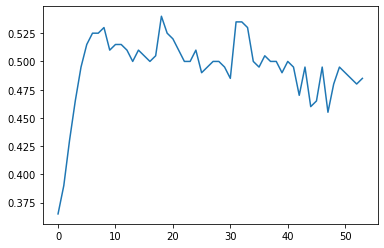

In [46]:
plt.plot(accuracy_array)

In [47]:
print(max(accuracy_array))

0.54


In [48]:
print(accuracy_array[-1])

0.485


In [49]:
df_to_save = pd.DataFrame(accuracy_array)

In [50]:
df_to_save.to_csv('accuracy_array_harrygan_E.csv')